# SegNet implementation in PyTorch


Move the frame to colab [**Done**]

Mount data [**done**]

Fix the training function [**Done**]

Report training accuracy [**Done**]

Learning Rate decay and cooldown [**Done**]

Save checkpints [**Done**]

Visualize an output [**Done**]

Plot training curve [**Pending**]

Calculate class weights [**Pending**]

Online Data Augmentation [**Pending**]

Try different loss functions (Focal, boundry) [**Pending**]

Quantitive evaluation (IOU, accuracy, etc) [**Pending**]

Video visualization [**Pending**]

Demo on CamVid Seq01, Kitti(preprocessing?) [**Pending**]


In [1]:
# import necessary libraries
%matplotlib inline
from matplotlib import pyplot as plt
import torch
from torchvision import models
import torchsummary
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data import DataLoader
import time
import os



In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# !ls gdrive/MyDrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# get the patht to the camvid data
camvid_path = r'/content/gdrive/MyDrive/CamVid'
!ls '/content/gdrive/MyDrive/CamVid'

# get the path to the scripts
!ls gdrive/MyDrive/Segmentation/code

# access necessary code
from gdrive.MyDrive.Segmentation.code.model import SegNet
import gdrive.MyDrive.Segmentation.code.data as data

class_dict.csv	test  test_labels  train  train_labels	val  val_labels
data.py  eval.py  loss.py  model.py  __pycache__  train.py  train_resnet.py


## Global vars

In [139]:
# for reproduction
torch.manual_seed(123)

# Pre config
IN_CHANNELS = 3
NUM_CLASS = 2

# training parameters
NUM_EPOCHS = 200
LEARNING_RATE = 0.1   # will decrease with epoch growing larger
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
LABEL_WEIGHTS = torch.FloatTensor([0.5, 2.3])
WEIGHT_DECAY = 0.0005
NUM_WORKERS = 16
PIN_MEMORY = False

## Reporting/Evaluation Functions

In [4]:
def avg_pixelwise_accuracy(model, dataset):

  if not dataset:
    return -1

  # change to eval mode
  model.eval()

  # get the dataloader using large batch since only forward pass required
  loader = DataLoader(dataset=dataset, 
                      batch_size=16, 
                      )
  
  correct, total = 0, 0
  for i, batch in enumerate(loader):

    # mount to GPU if available [Need to fix y]
    imgs, labels = batch['X'].to(DEVICE), batch['y'][:, 1, :, :].to(DEVICE)

    # argmax X along dim 1
    out = model(imgs)
    predicted = torch.argmax(out, dim=1)
    total += labels.nelement()
    correct += predicted.eq(labels).sum().item()

  return correct / total


## Save/Load checkpoints

In [5]:
def save_checkpoints(model, filename, epoch, optimizer, loss, train_acc, valid_acc):

  dirname = "/content/gdrive/MyDrive/Segmentation/check_points"

  save_path = os.path.join(dirname, filename)
  print(save_path)
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_acc': train_acc,
            'valid_acc': valid_acc,
            'transfer_learning': TRANSFER_LEARNING
            }, save_path)


def load_checkpoints(filename, transfer_learning=True):

  dirname = "/content/gdrive/MyDrive/Segmentation/check_points"
  file_path = os.path.join(dirname, filename)
  checkpoint = torch.load(file_path)
  if 'transfer_learning' in checkpoint:
    transfer_learning = checkpoint['transfer_learning']
  model = SegNet(IN_CHANNELS, NUM_CLASS, transfer_learning=transfer_learning)
  model.load_state_dict(checkpoint['model_state_dict'])

  print("Model Loaded: Epoch#{}\tLoss:{:.4f}\tTrainAcc:{:.4f}\tValidAcc:{:.4f}".format(
      checkpoint['epoch'],
      checkpoint['loss'],
      checkpoint['train_acc'],
      checkpoint['valid_acc'],
  ))
  return model.to(DEVICE)


# model2 = load_checkpoints("Epoch1_loss59.1495_trainacc31.217_valacc28.866.pth")
# model2

## Visualization

In [132]:
def show_img(img_tensor):

  if len(img_tensor.shape) == 4:
    img = img_tensor.squeeze()
  else:
    img = img_tensor
  img = torch.movedim(img, 0, -1).type(torch.uint8).numpy()[:,:,::-1]
  plt.imshow(img)
  plt.show()

def show_mask(mask_tensor):
  # shape height x width, single channel
  plt.imshow(mask_tensor)
  plt.show()

def show_pred_mask(model, img_tensor):
  if len(img_tensor.shape) == 4:
    source_img = img_tensor
  else:
    source_img = img_tensor.unsqueeze(0).to(DEVICE)
  
  model.eval()
  out = model(source_img)
  predicted = torch.argmax(out, dim=1)
  predicted = predicted.cpu().data.numpy()[0, :]
  plt.imshow(predicted)
  plt.show()

def show_all(model, img_tensor, mask_tensor, cmap='jet'):

  # regulate the image tensor
  if len(img_tensor.shape) == 4:
    img = img_tensor.squeeze()
    source_img = img_tensor
  else:
    img = img_tensor
    source_img = img_tensor.unsqueeze(0).to(DEVICE)
  
  # Raw image
  img = torch.movedim(img, 0, -1).type(torch.uint8).numpy()[:,:,::-1]
  
  # Ground Truth mask
  mask = mask_tensor

  # predicted mask
  model.eval()
  out = model(source_img)
  predicted = torch.argmax(out, dim=1)
  predicted = predicted.cpu().data.numpy()[0, :]

  fig, axs = plt.subplots(1, 5, figsize=(20, 20), constrained_layout=True)

  axs[0].imshow(img)
  axs[0].set_title("Image")

  axs[1].imshow(mask)
  axs[1].set_title("Ground Truth")

  axs[2].imshow(predicted)
  axs[2].set_title("SegNet Outcome")

  img[:, :, 1] += (predicted * 255 * 0.15).astype(np.uint8)
  img[:, :, 0] += (predicted * 255 * 0.3).astype(np.uint8)
  axs[3].imshow(img, vmin=0, vmax=255)
  # axs[3].imshow(predicted, cmap=cmap, alpha=0.3)
  axs[3].set_title("SegNet Overlay")

  axs[4].imshow((predicted - mask.numpy()) ** 2)
  axs[4].set_title("Error")

  plt.show()



## Dataset Preparation

In [7]:
# load the dataset
X_train, y_train = data.load_data(camvid_path+"/train")
print("Loaded {} training samples".format(len(X_train)))


X_valid, y_valid = data.load_data(camvid_path+"/val")
print("Loaded {} validation samples".format(len(X_valid)))


X_test, y_test = data.load_data(camvid_path+"/test")
print("Loaded {} testing samples".format(len(X_test)))


Loaded 367 training samples
Loaded 101 validation samples
Loaded 233 testing samples


## Train

In [49]:
# train function
def train(model, optimizer, loss_fn, X_train, y_train, X_valid=None, y_valid=None):

  # get the dataloader
  train_dataset = data.CamVidDataset(X_train, y_train)
  train_loader = DataLoader(dataset=train_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_WORKERS,
                            pin_memory=False,
                            shuffle=True,
                            drop_last=True,
                            worker_init_fn=None
                            )

  valid_dataset = data.CamVidDataset(X_valid, y_valid) if X_valid is not None else None

  
  # for plotting and logging
  iters, losses, train_acc, val_acc, iter_counter = [], [], [], [], 0

  # for checkpoints
  checkpoint_path_template = "Epoch{}_loss{:.4f}_trainacc{:.3f}_valacc{:.3f}.pth"
  acc_recoder, save_gap = 97.7, 0.15
  
  # start training
  for epoch in range(NUM_EPOCHS):

    # visualize an segmentation every 10 epoch
    if epoch % 10 == 0:
      show_all(model, X_valid[0, :], y_valid[0, 1, :])

    # Learning Rate Decay [Optional]
    if (epoch + 1) % 20 == 0:
      optimizer.param_groups[0]['lr'] /= 3
      print("<=============== Learning Rate {} -> {}===== ==========>".format(optimizer.param_groups[0]['lr'] * 3, optimizer.param_groups[0]['lr']))

    epoch_loss = 0
    t_start = time.time()
    for i, batch in enumerate(train_loader):

      # mount to GPU if available [Need to fix y]
      imgs, labels = batch['X'].to(DEVICE), batch['y'][:, 1, :, :].to(DEVICE)

      # change the mode to training mode and step training
      model.train()
      out = model(imgs)
      loss = loss_fn(out, labels)   # note: soft-max should not be used here since it's included in nn.CrossEntropyLoss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      iter_counter += 1

      # save the current training information, TODO
      losses.append(loss)
      epoch_loss += loss

    delta = time.time() - t_start

    # train_acc = avg_pixelwise_accuracy(model, train_dataset)
    train_acc = avg_pixelwise_accuracy(model, train_dataset) * 100
    valid_acc = avg_pixelwise_accuracy(model, valid_dataset) * 100
    print("Epoch #{}\tLoss: {:.6f}\tTrain Acc: {:.3f}%\tValid Acc: {:.3f}%\tTime: {:.2f}s".format(epoch+1, epoch_loss, train_acc, valid_acc, delta))

    # Save checkpoints
    if valid_acc > acc_recoder + save_gap:
      acc_recoder = valid_acc
      checkpoint_name = checkpoint_path_template.format(epoch+1, epoch_loss, train_acc, valid_acc)
      save_checkpoints(model, checkpoint_name, epoch+1, optimizer, epoch_loss, train_acc, valid_acc)



### Train from scratch

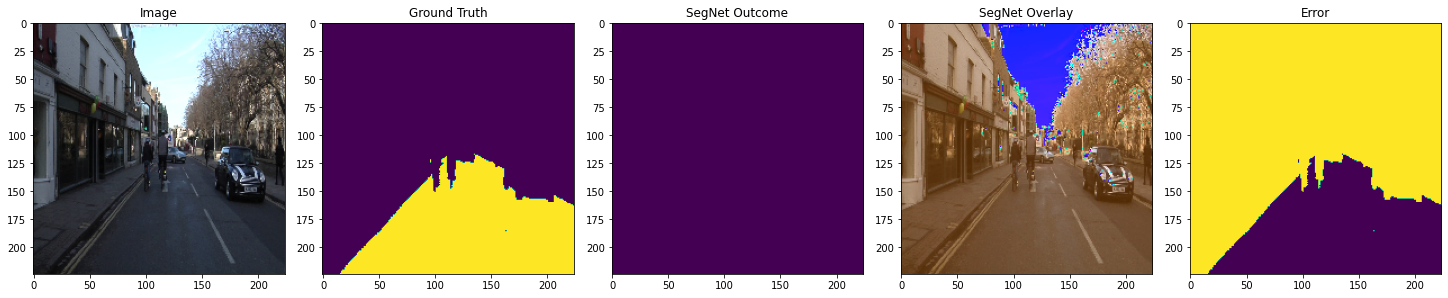

Epoch #1	Loss: 59.959072	Train Acc: 82.153%	Valid Acc: 88.829%	Time: 5.25s
Epoch #2	Loss: 13.369540	Train Acc: 91.559%	Valid Acc: 92.052%	Time: 5.28s
Epoch #3	Loss: 6.906309	Train Acc: 93.842%	Valid Acc: 90.620%	Time: 5.26s
Epoch #4	Loss: 6.195933	Train Acc: 88.328%	Valid Acc: 86.300%	Time: 5.24s
Epoch #5	Loss: 6.060074	Train Acc: 92.622%	Valid Acc: 93.097%	Time: 5.23s
Epoch #6	Loss: 5.623681	Train Acc: 92.988%	Valid Acc: 90.458%	Time: 5.23s
Epoch #7	Loss: 4.998490	Train Acc: 93.849%	Valid Acc: 91.194%	Time: 5.24s
Epoch #8	Loss: 4.660867	Train Acc: 90.442%	Valid Acc: 93.565%	Time: 5.23s
Epoch #9	Loss: 5.115431	Train Acc: 92.707%	Valid Acc: 89.077%	Time: 5.25s
Epoch #10	Loss: 4.160519	Train Acc: 95.804%	Valid Acc: 93.989%	Time: 5.24s


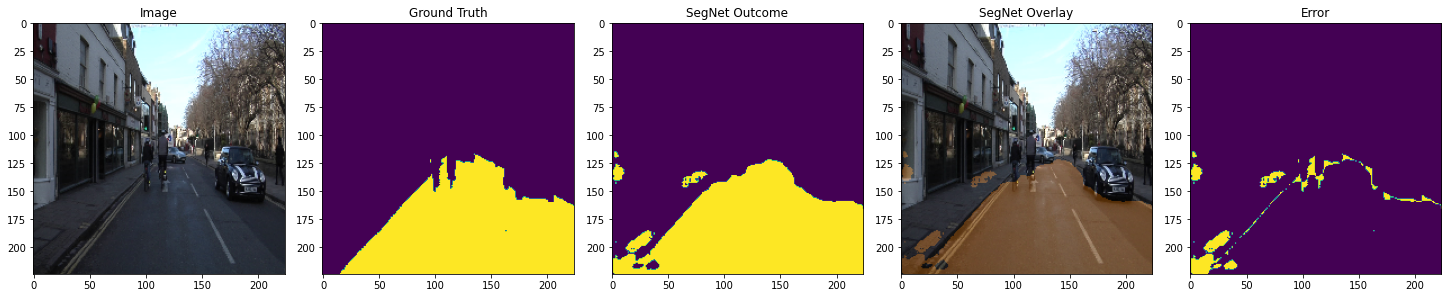

Epoch #11	Loss: 4.129129	Train Acc: 96.482%	Valid Acc: 96.068%	Time: 5.23s
Epoch #12	Loss: 4.236888	Train Acc: 95.842%	Valid Acc: 93.767%	Time: 5.26s
Epoch #13	Loss: 4.431211	Train Acc: 96.104%	Valid Acc: 95.283%	Time: 5.26s
Epoch #14	Loss: 4.016316	Train Acc: 94.217%	Valid Acc: 92.146%	Time: 5.25s
Epoch #15	Loss: 3.949139	Train Acc: 95.147%	Valid Acc: 94.272%	Time: 5.24s
Epoch #16	Loss: 3.753753	Train Acc: 96.670%	Valid Acc: 96.111%	Time: 5.25s
Epoch #17	Loss: 3.764382	Train Acc: 94.688%	Valid Acc: 92.339%	Time: 5.28s
Epoch #18	Loss: 3.784114	Train Acc: 96.658%	Valid Acc: 96.754%	Time: 5.26s
Epoch #19	Loss: 3.994881	Train Acc: 96.739%	Valid Acc: 97.128%	Time: 5.27s
<=============== Learning Rate 0.1 -> 0.03333333333333333===== ==========>
Epoch #20	Loss: 3.204739	Train Acc: 95.455%	Valid Acc: 94.286%	Time: 5.28s


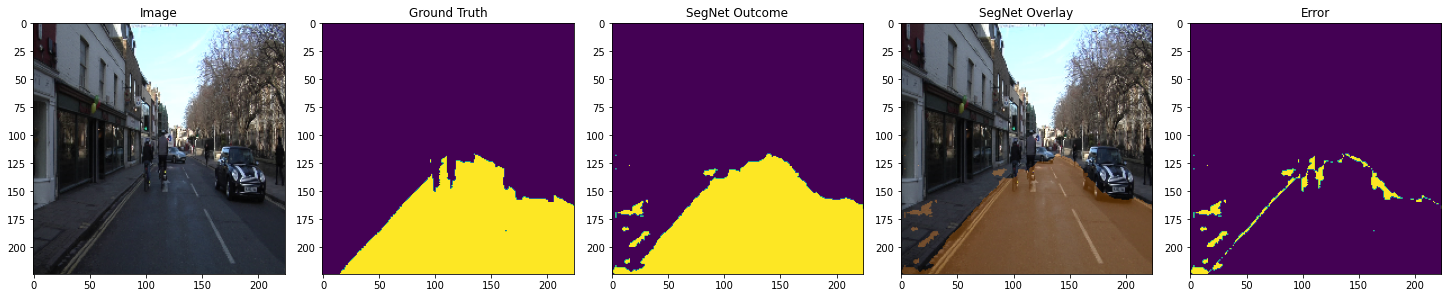

Epoch #21	Loss: 3.103426	Train Acc: 96.726%	Valid Acc: 96.759%	Time: 5.28s
Epoch #22	Loss: 2.990434	Train Acc: 96.674%	Valid Acc: 96.988%	Time: 5.26s
Epoch #23	Loss: 3.145272	Train Acc: 95.695%	Valid Acc: 94.552%	Time: 5.24s
Epoch #24	Loss: 3.007056	Train Acc: 95.763%	Valid Acc: 95.532%	Time: 5.27s
Epoch #25	Loss: 2.970124	Train Acc: 95.427%	Valid Acc: 94.130%	Time: 5.26s
Epoch #26	Loss: 2.910323	Train Acc: 96.258%	Valid Acc: 96.145%	Time: 5.24s
Epoch #27	Loss: 2.917727	Train Acc: 96.219%	Valid Acc: 95.654%	Time: 5.30s
Epoch #28	Loss: 2.899012	Train Acc: 97.273%	Valid Acc: 97.664%	Time: 5.30s
Epoch #29	Loss: 2.984113	Train Acc: 95.902%	Valid Acc: 96.443%	Time: 5.27s
Epoch #30	Loss: 2.713775	Train Acc: 96.318%	Valid Acc: 96.356%	Time: 5.26s


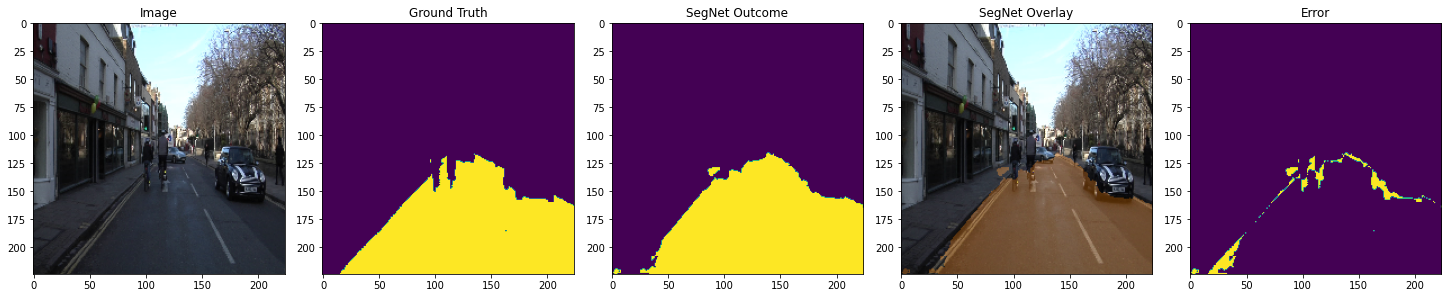

Epoch #31	Loss: 2.709745	Train Acc: 96.603%	Valid Acc: 97.061%	Time: 5.27s
Epoch #32	Loss: 2.790483	Train Acc: 96.598%	Valid Acc: 96.604%	Time: 5.27s
Epoch #33	Loss: 2.703732	Train Acc: 97.099%	Valid Acc: 97.419%	Time: 5.26s
Epoch #34	Loss: 2.563538	Train Acc: 96.217%	Valid Acc: 96.722%	Time: 5.27s
Epoch #35	Loss: 2.623943	Train Acc: 97.257%	Valid Acc: 97.868%	Time: 5.27s
/content/gdrive/MyDrive/Segmentation/check_points/Epoch35_loss2.6239_trainacc97.257_valacc97.868.pth
Epoch #36	Loss: 2.672762	Train Acc: 96.059%	Valid Acc: 96.472%	Time: 5.35s
Epoch #37	Loss: 2.607290	Train Acc: 96.629%	Valid Acc: 96.523%	Time: 5.44s
Epoch #38	Loss: 2.627444	Train Acc: 96.266%	Valid Acc: 97.113%	Time: 5.35s
Epoch #39	Loss: 2.723114	Train Acc: 97.076%	Valid Acc: 97.357%	Time: 5.35s
<=============== Learning Rate 0.03333333333333333 -> 0.011111111111111112===== ==========>
Epoch #40	Loss: 2.390543	Train Acc: 96.866%	Valid Acc: 96.864%	Time: 5.37s


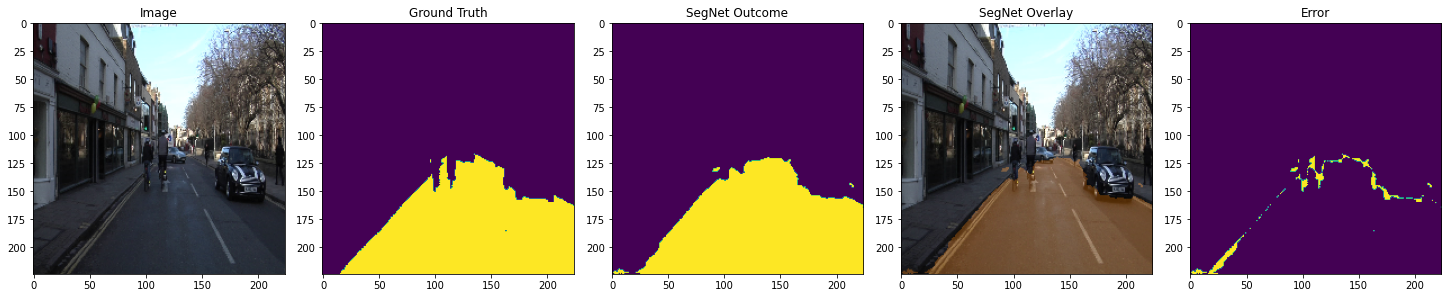

Epoch #41	Loss: 2.349404	Train Acc: 96.929%	Valid Acc: 97.018%	Time: 5.25s
Epoch #42	Loss: 2.374461	Train Acc: 97.252%	Valid Acc: 97.007%	Time: 5.27s
Epoch #43	Loss: 2.369855	Train Acc: 96.712%	Valid Acc: 96.959%	Time: 5.32s
Epoch #44	Loss: 2.309404	Train Acc: 97.083%	Valid Acc: 97.204%	Time: 5.31s
Epoch #45	Loss: 2.308764	Train Acc: 96.006%	Valid Acc: 95.641%	Time: 5.30s
Epoch #46	Loss: 2.277415	Train Acc: 97.294%	Valid Acc: 97.440%	Time: 5.33s
Epoch #47	Loss: 2.259809	Train Acc: 97.382%	Valid Acc: 97.544%	Time: 5.34s
Epoch #48	Loss: 2.278505	Train Acc: 97.543%	Valid Acc: 97.472%	Time: 5.32s
Epoch #49	Loss: 2.277631	Train Acc: 97.360%	Valid Acc: 97.434%	Time: 5.31s
Epoch #50	Loss: 2.278362	Train Acc: 97.264%	Valid Acc: 97.441%	Time: 5.32s


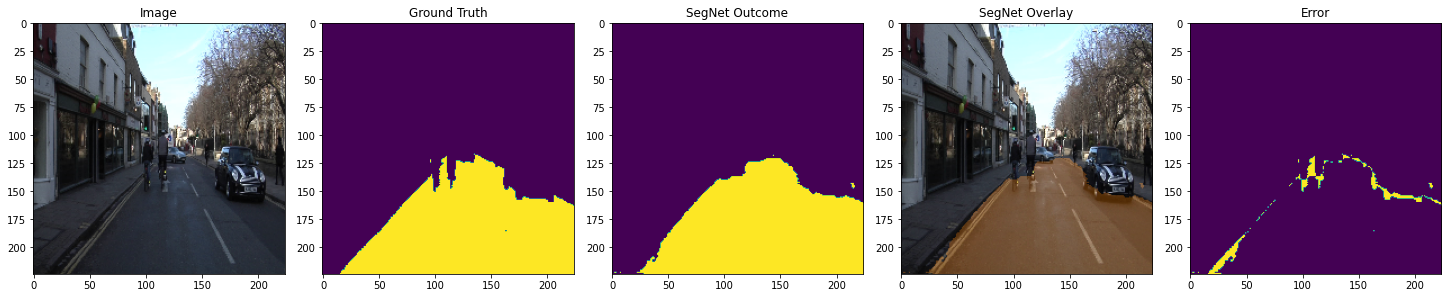

Epoch #51	Loss: 2.230949	Train Acc: 97.510%	Valid Acc: 97.468%	Time: 5.44s
Epoch #52	Loss: 2.189181	Train Acc: 97.159%	Valid Acc: 97.038%	Time: 5.41s
Epoch #53	Loss: 2.304378	Train Acc: 97.181%	Valid Acc: 97.145%	Time: 5.42s
Epoch #54	Loss: 2.182875	Train Acc: 97.295%	Valid Acc: 97.550%	Time: 5.43s
Epoch #55	Loss: 2.207233	Train Acc: 97.646%	Valid Acc: 97.741%	Time: 5.42s
Epoch #56	Loss: 2.221341	Train Acc: 96.951%	Valid Acc: 96.797%	Time: 5.41s
Epoch #57	Loss: 2.170622	Train Acc: 97.245%	Valid Acc: 97.099%	Time: 5.43s
Epoch #58	Loss: 2.136117	Train Acc: 97.862%	Valid Acc: 97.630%	Time: 5.42s
Epoch #59	Loss: 2.231509	Train Acc: 97.929%	Valid Acc: 97.786%	Time: 5.40s
<=============== Learning Rate 0.011111111111111112 -> 0.003703703703703704===== ==========>
Epoch #60	Loss: 2.254554	Train Acc: 97.555%	Valid Acc: 97.529%	Time: 5.43s


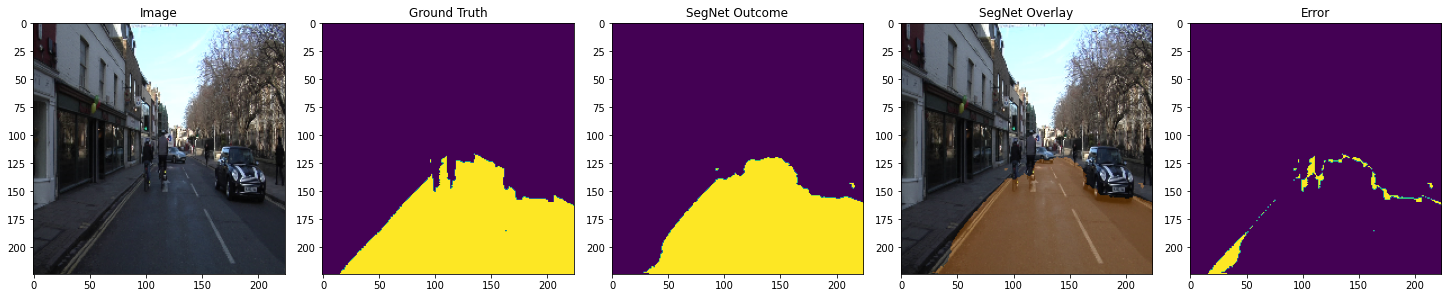

Epoch #61	Loss: 2.068772	Train Acc: 97.766%	Valid Acc: 97.619%	Time: 5.42s
Epoch #62	Loss: 1.966498	Train Acc: 97.447%	Valid Acc: 97.436%	Time: 5.42s
Epoch #63	Loss: 2.020751	Train Acc: 97.585%	Valid Acc: 97.484%	Time: 5.43s
Epoch #64	Loss: 1.955480	Train Acc: 97.525%	Valid Acc: 97.430%	Time: 5.42s
Epoch #65	Loss: 2.013111	Train Acc: 97.565%	Valid Acc: 97.486%	Time: 5.42s
Epoch #66	Loss: 1.942039	Train Acc: 97.661%	Valid Acc: 97.725%	Time: 5.44s
Epoch #67	Loss: 1.976838	Train Acc: 97.437%	Valid Acc: 97.480%	Time: 5.42s
Epoch #68	Loss: 1.955902	Train Acc: 97.379%	Valid Acc: 97.535%	Time: 5.43s
Epoch #69	Loss: 1.939366	Train Acc: 97.807%	Valid Acc: 97.609%	Time: 5.42s
Epoch #70	Loss: 1.933293	Train Acc: 97.282%	Valid Acc: 97.392%	Time: 5.42s


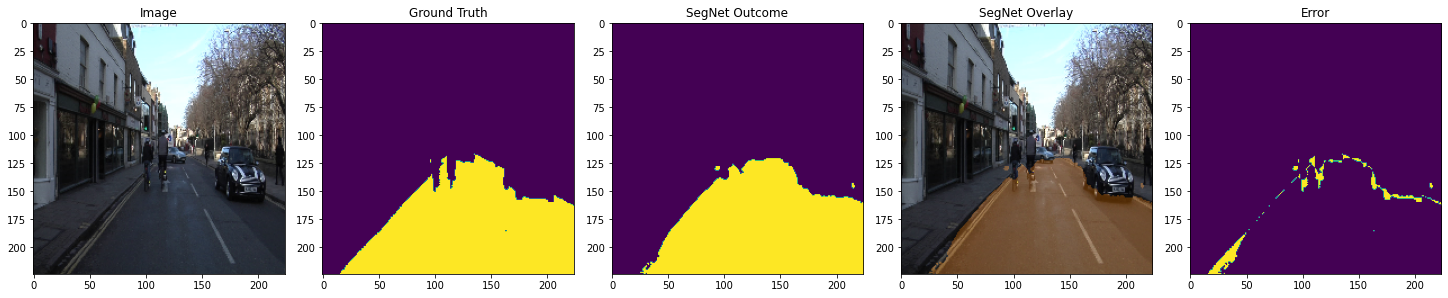

Epoch #71	Loss: 1.983405	Train Acc: 97.271%	Valid Acc: 97.285%	Time: 5.44s
Epoch #72	Loss: 1.997146	Train Acc: 97.652%	Valid Acc: 97.513%	Time: 5.43s
Epoch #73	Loss: 1.906574	Train Acc: 97.833%	Valid Acc: 97.724%	Time: 5.41s
Epoch #74	Loss: 1.942118	Train Acc: 97.524%	Valid Acc: 97.372%	Time: 5.41s
Epoch #75	Loss: 1.985250	Train Acc: 97.316%	Valid Acc: 97.530%	Time: 5.42s
Epoch #76	Loss: 1.868611	Train Acc: 97.523%	Valid Acc: 97.376%	Time: 5.45s
Epoch #77	Loss: 1.922863	Train Acc: 97.983%	Valid Acc: 97.877%	Time: 5.43s
Epoch #78	Loss: 1.874818	Train Acc: 97.631%	Valid Acc: 97.704%	Time: 5.43s
Epoch #79	Loss: 1.839368	Train Acc: 97.767%	Valid Acc: 97.521%	Time: 5.40s
<=============== Learning Rate 0.003703703703703704 -> 0.0012345679012345679===== ==========>
Epoch #80	Loss: 1.872981	Train Acc: 97.726%	Valid Acc: 97.751%	Time: 5.42s


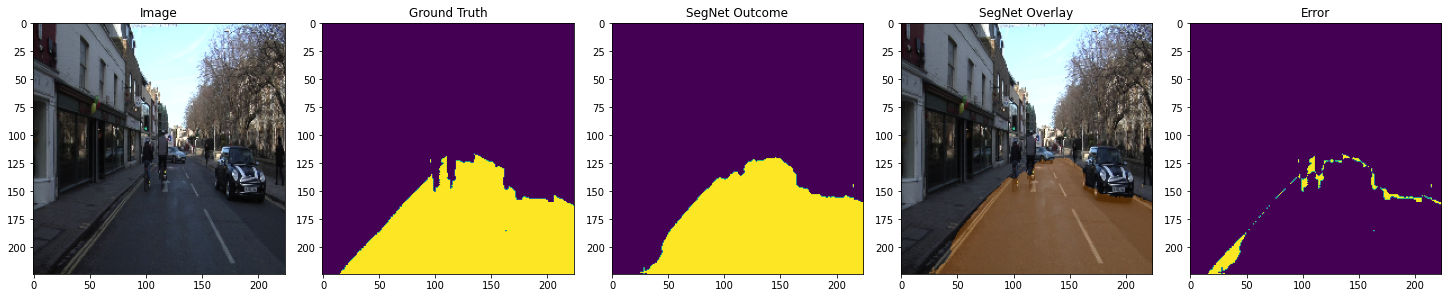

Epoch #81	Loss: 1.836741	Train Acc: 97.755%	Valid Acc: 97.705%	Time: 5.31s
Epoch #82	Loss: 1.826309	Train Acc: 97.873%	Valid Acc: 97.756%	Time: 5.33s
Epoch #83	Loss: 1.805521	Train Acc: 97.783%	Valid Acc: 97.643%	Time: 5.34s
Epoch #84	Loss: 1.791509	Train Acc: 97.712%	Valid Acc: 97.644%	Time: 5.32s
Epoch #85	Loss: 1.841038	Train Acc: 97.619%	Valid Acc: 97.517%	Time: 5.36s
Epoch #86	Loss: 1.801186	Train Acc: 97.828%	Valid Acc: 97.639%	Time: 5.34s
Epoch #87	Loss: 1.828166	Train Acc: 97.782%	Valid Acc: 97.800%	Time: 5.36s
Epoch #88	Loss: 1.766195	Train Acc: 97.715%	Valid Acc: 97.708%	Time: 5.40s
Epoch #89	Loss: 1.815001	Train Acc: 97.635%	Valid Acc: 97.528%	Time: 5.44s
Epoch #90	Loss: 1.792464	Train Acc: 97.916%	Valid Acc: 97.762%	Time: 5.45s


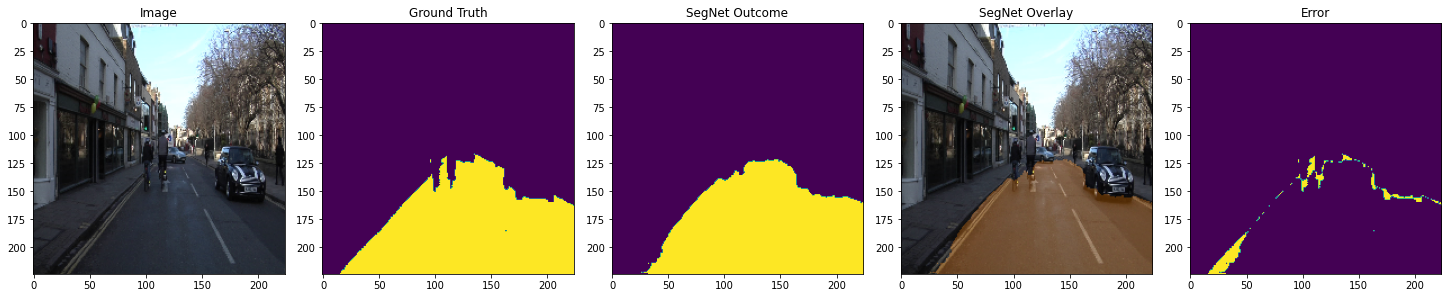

Epoch #91	Loss: 1.792109	Train Acc: 97.605%	Valid Acc: 97.691%	Time: 5.45s
Epoch #92	Loss: 1.764530	Train Acc: 97.758%	Valid Acc: 97.683%	Time: 5.42s
Epoch #93	Loss: 1.783654	Train Acc: 97.819%	Valid Acc: 97.762%	Time: 5.45s
Epoch #94	Loss: 1.821485	Train Acc: 97.791%	Valid Acc: 97.789%	Time: 5.44s
Epoch #95	Loss: 1.772226	Train Acc: 97.756%	Valid Acc: 97.642%	Time: 5.42s
Epoch #96	Loss: 1.739422	Train Acc: 97.866%	Valid Acc: 97.766%	Time: 5.43s
Epoch #97	Loss: 1.753517	Train Acc: 97.747%	Valid Acc: 97.724%	Time: 5.44s
Epoch #98	Loss: 1.745910	Train Acc: 97.910%	Valid Acc: 97.835%	Time: 5.44s
Epoch #99	Loss: 1.823162	Train Acc: 97.813%	Valid Acc: 97.741%	Time: 5.42s
<=============== Learning Rate 0.0012345679012345679 -> 0.00041152263374485596===== ==========>
Epoch #100	Loss: 1.810884	Train Acc: 97.811%	Valid Acc: 97.657%	Time: 5.42s


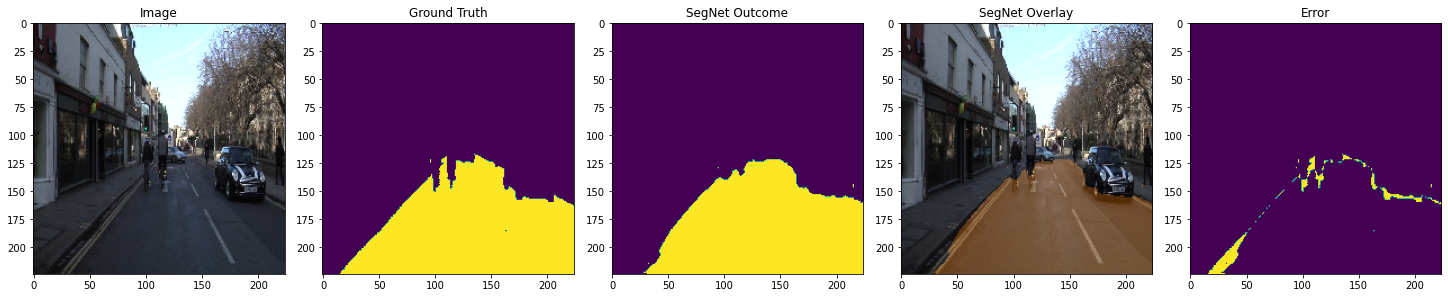

Epoch #101	Loss: 1.732841	Train Acc: 97.775%	Valid Acc: 97.691%	Time: 5.43s
Epoch #102	Loss: 1.780017	Train Acc: 97.861%	Valid Acc: 97.747%	Time: 5.43s
Epoch #103	Loss: 1.708575	Train Acc: 97.757%	Valid Acc: 97.634%	Time: 5.43s
Epoch #104	Loss: 1.726286	Train Acc: 97.879%	Valid Acc: 97.755%	Time: 5.43s
Epoch #105	Loss: 1.793692	Train Acc: 97.897%	Valid Acc: 97.751%	Time: 5.44s
Epoch #106	Loss: 1.735782	Train Acc: 97.745%	Valid Acc: 97.697%	Time: 5.42s
Epoch #107	Loss: 1.751414	Train Acc: 97.819%	Valid Acc: 97.641%	Time: 5.41s
Epoch #108	Loss: 1.766666	Train Acc: 97.875%	Valid Acc: 97.742%	Time: 5.44s
Epoch #109	Loss: 1.743301	Train Acc: 97.873%	Valid Acc: 97.759%	Time: 5.42s
Epoch #110	Loss: 1.751295	Train Acc: 97.937%	Valid Acc: 97.779%	Time: 5.42s


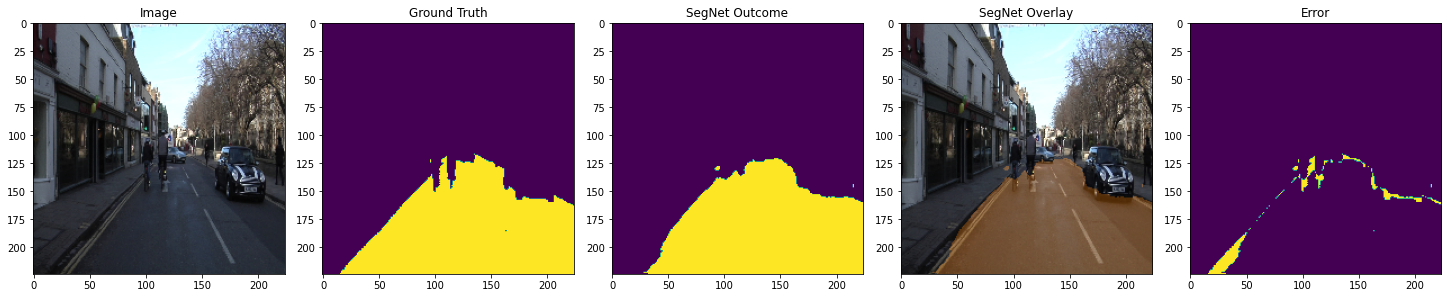

Epoch #111	Loss: 1.728826	Train Acc: 97.915%	Valid Acc: 97.844%	Time: 5.43s
Epoch #112	Loss: 1.720947	Train Acc: 97.793%	Valid Acc: 97.731%	Time: 5.45s
Epoch #113	Loss: 1.731299	Train Acc: 97.855%	Valid Acc: 97.697%	Time: 5.42s
Epoch #114	Loss: 1.678497	Train Acc: 97.956%	Valid Acc: 97.849%	Time: 5.43s
Epoch #115	Loss: 1.719613	Train Acc: 97.798%	Valid Acc: 97.748%	Time: 5.42s
Epoch #116	Loss: 1.729468	Train Acc: 97.804%	Valid Acc: 97.736%	Time: 5.40s
Epoch #117	Loss: 1.765408	Train Acc: 97.991%	Valid Acc: 97.836%	Time: 5.42s
Epoch #118	Loss: 1.668367	Train Acc: 97.850%	Valid Acc: 97.751%	Time: 5.40s
Epoch #119	Loss: 1.718658	Train Acc: 97.828%	Valid Acc: 97.740%	Time: 5.43s
<=============== Learning Rate 0.00041152263374485596 -> 0.00013717421124828533===== ==========>
Epoch #120	Loss: 1.753451	Train Acc: 97.898%	Valid Acc: 97.694%	Time: 5.43s


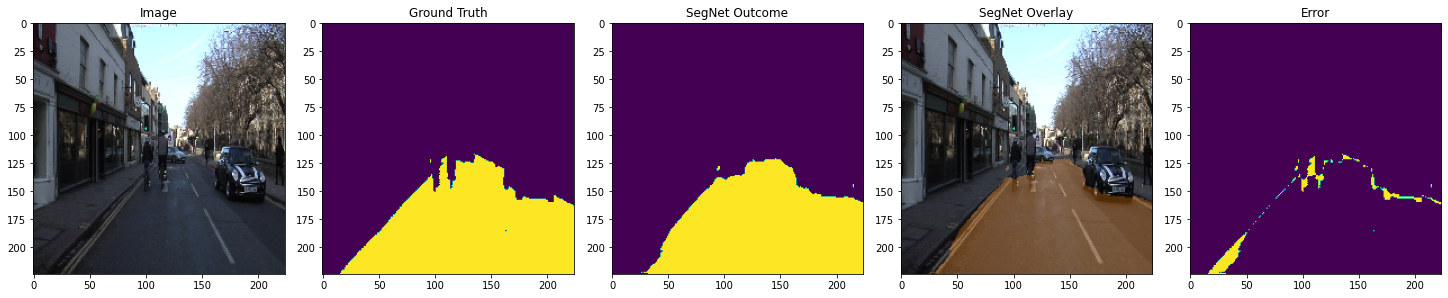

Epoch #121	Loss: 1.741181	Train Acc: 97.827%	Valid Acc: 97.636%	Time: 5.35s
Epoch #122	Loss: 1.701823	Train Acc: 97.930%	Valid Acc: 97.727%	Time: 5.33s
Epoch #123	Loss: 1.738978	Train Acc: 97.839%	Valid Acc: 97.767%	Time: 5.36s
Epoch #124	Loss: 1.743683	Train Acc: 97.894%	Valid Acc: 97.709%	Time: 5.34s
Epoch #125	Loss: 1.701288	Train Acc: 97.893%	Valid Acc: 97.784%	Time: 5.34s
Epoch #126	Loss: 1.765735	Train Acc: 97.824%	Valid Acc: 97.684%	Time: 5.37s
Epoch #127	Loss: 1.720961	Train Acc: 97.856%	Valid Acc: 97.708%	Time: 5.37s
Epoch #128	Loss: 1.755831	Train Acc: 97.854%	Valid Acc: 97.740%	Time: 5.42s
Epoch #129	Loss: 1.752398	Train Acc: 97.866%	Valid Acc: 97.604%	Time: 5.44s
Epoch #130	Loss: 1.693125	Train Acc: 97.931%	Valid Acc: 97.729%	Time: 5.41s


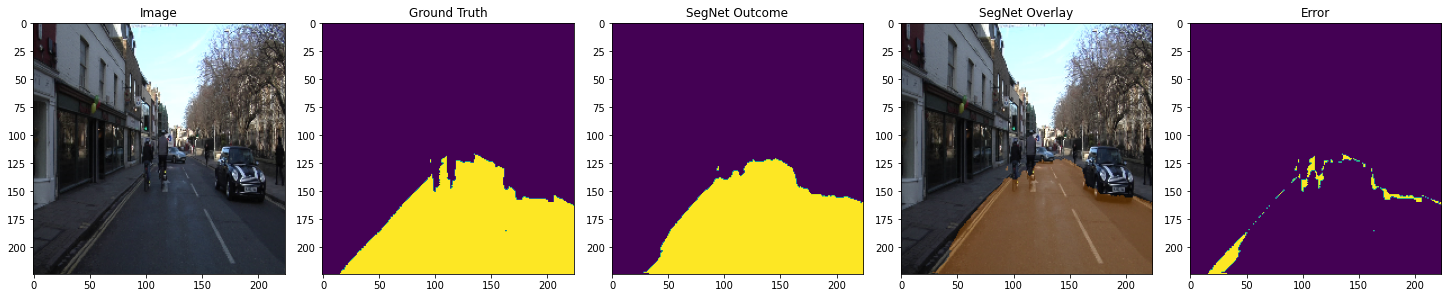

Epoch #131	Loss: 1.697234	Train Acc: 97.848%	Valid Acc: 97.724%	Time: 5.42s
Epoch #132	Loss: 1.702008	Train Acc: 97.896%	Valid Acc: 97.781%	Time: 5.43s
Epoch #133	Loss: 1.707089	Train Acc: 97.894%	Valid Acc: 97.748%	Time: 5.44s
Epoch #134	Loss: 1.692773	Train Acc: 97.889%	Valid Acc: 97.734%	Time: 5.43s
Epoch #135	Loss: 1.726954	Train Acc: 97.850%	Valid Acc: 97.697%	Time: 5.43s
Epoch #136	Loss: 1.705521	Train Acc: 97.972%	Valid Acc: 97.815%	Time: 5.43s
Epoch #137	Loss: 1.725462	Train Acc: 97.911%	Valid Acc: 97.775%	Time: 5.42s
Epoch #138	Loss: 1.664373	Train Acc: 97.907%	Valid Acc: 97.759%	Time: 5.43s
Epoch #139	Loss: 1.715795	Train Acc: 97.860%	Valid Acc: 97.712%	Time: 5.43s
<=============== Learning Rate 0.00013717421124828533 -> 4.5724737082761774e-05===== ==========>
Epoch #140	Loss: 1.671603	Train Acc: 97.881%	Valid Acc: 97.742%	Time: 5.43s


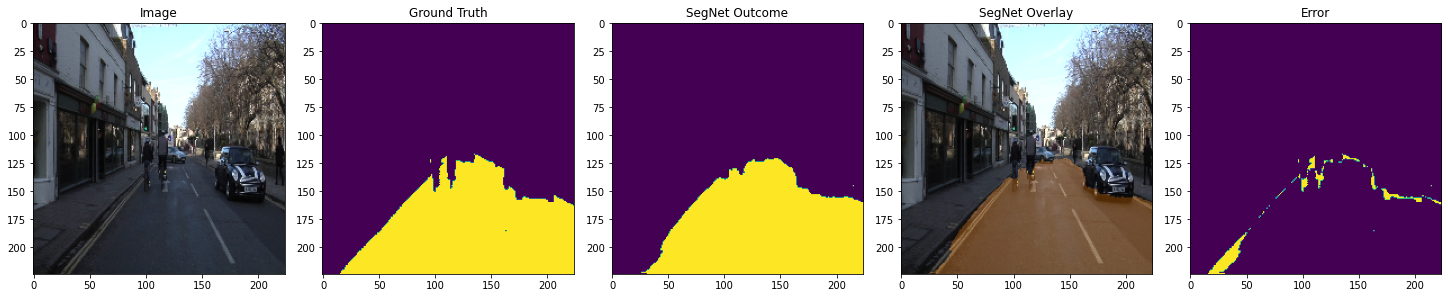

Epoch #141	Loss: 1.725349	Train Acc: 97.895%	Valid Acc: 97.775%	Time: 5.44s
Epoch #142	Loss: 1.689886	Train Acc: 97.916%	Valid Acc: 97.781%	Time: 5.44s
Epoch #143	Loss: 1.691137	Train Acc: 97.912%	Valid Acc: 97.725%	Time: 5.42s
Epoch #144	Loss: 1.722602	Train Acc: 97.914%	Valid Acc: 97.762%	Time: 5.43s
Epoch #145	Loss: 1.731226	Train Acc: 97.908%	Valid Acc: 97.747%	Time: 5.44s
Epoch #146	Loss: 1.684404	Train Acc: 97.848%	Valid Acc: 97.690%	Time: 5.42s
Epoch #147	Loss: 1.713279	Train Acc: 97.928%	Valid Acc: 97.752%	Time: 5.42s
Epoch #148	Loss: 1.757845	Train Acc: 97.858%	Valid Acc: 97.713%	Time: 5.40s
Epoch #149	Loss: 1.691908	Train Acc: 97.848%	Valid Acc: 97.715%	Time: 5.43s
Epoch #150	Loss: 1.736706	Train Acc: 97.933%	Valid Acc: 97.773%	Time: 5.43s


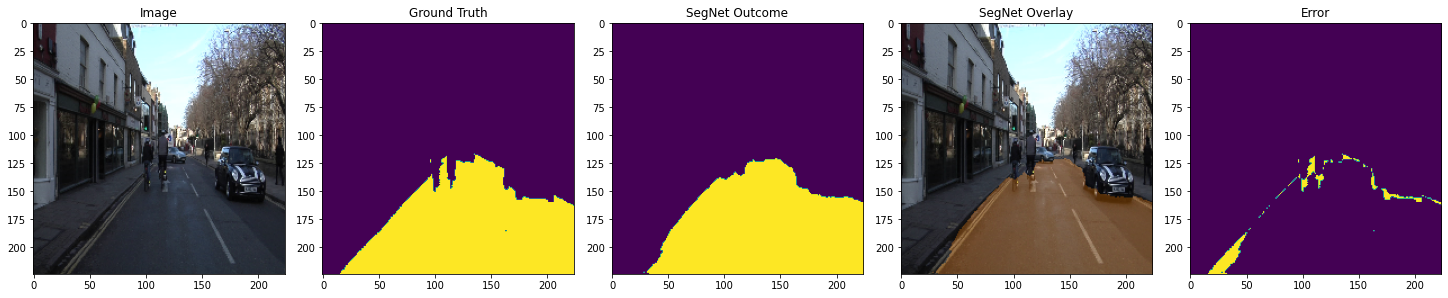

Epoch #151	Loss: 1.740677	Train Acc: 97.879%	Valid Acc: 97.716%	Time: 5.43s
Epoch #152	Loss: 1.714523	Train Acc: 97.869%	Valid Acc: 97.685%	Time: 5.43s
Epoch #153	Loss: 1.690116	Train Acc: 97.924%	Valid Acc: 97.681%	Time: 5.42s
Epoch #154	Loss: 1.674247	Train Acc: 97.899%	Valid Acc: 97.729%	Time: 5.44s
Epoch #155	Loss: 1.751272	Train Acc: 97.845%	Valid Acc: 97.672%	Time: 5.41s
Epoch #156	Loss: 1.696889	Train Acc: 97.882%	Valid Acc: 97.721%	Time: 5.45s
Epoch #157	Loss: 1.698645	Train Acc: 97.852%	Valid Acc: 97.688%	Time: 5.44s
Epoch #158	Loss: 1.700448	Train Acc: 97.897%	Valid Acc: 97.780%	Time: 5.44s
Epoch #159	Loss: 1.687741	Train Acc: 97.876%	Valid Acc: 97.735%	Time: 5.46s
<=============== Learning Rate 4.5724737082761774e-05 -> 1.5241579027587257e-05===== ==========>
Epoch #160	Loss: 1.696836	Train Acc: 97.890%	Valid Acc: 97.730%	Time: 5.44s


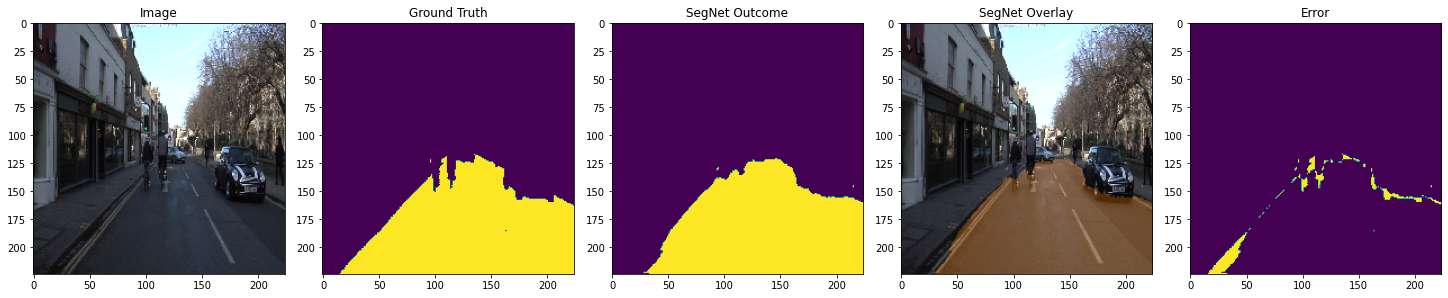

Epoch #161	Loss: 1.673381	Train Acc: 97.911%	Valid Acc: 97.778%	Time: 5.42s
Epoch #162	Loss: 1.704552	Train Acc: 97.910%	Valid Acc: 97.788%	Time: 5.40s
Epoch #163	Loss: 1.666442	Train Acc: 97.881%	Valid Acc: 97.716%	Time: 5.40s
Epoch #164	Loss: 1.679241	Train Acc: 97.895%	Valid Acc: 97.716%	Time: 5.39s
Epoch #165	Loss: 1.699520	Train Acc: 97.945%	Valid Acc: 97.787%	Time: 5.40s
Epoch #166	Loss: 1.704985	Train Acc: 97.953%	Valid Acc: 97.820%	Time: 5.39s
Epoch #167	Loss: 1.730816	Train Acc: 97.836%	Valid Acc: 97.735%	Time: 5.40s
Epoch #168	Loss: 1.682030	Train Acc: 97.916%	Valid Acc: 97.735%	Time: 5.44s
Epoch #169	Loss: 1.672667	Train Acc: 97.892%	Valid Acc: 97.724%	Time: 5.45s
Epoch #170	Loss: 1.684103	Train Acc: 97.861%	Valid Acc: 97.682%	Time: 5.41s


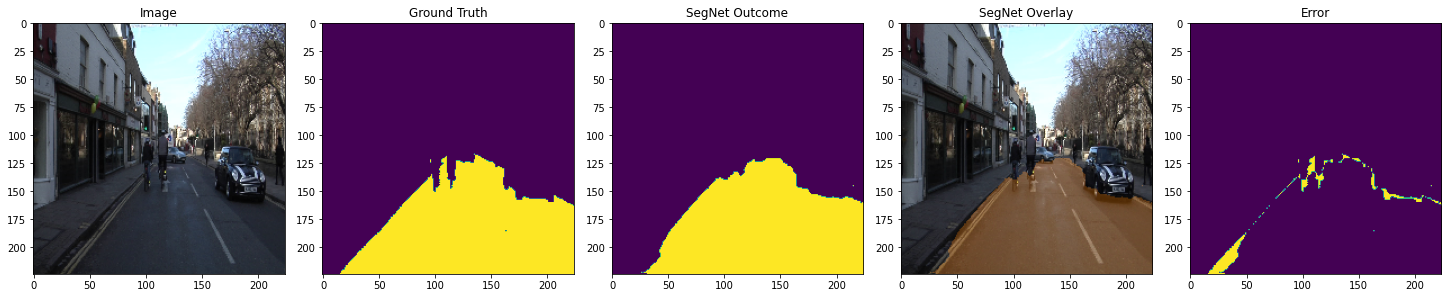

Epoch #171	Loss: 1.713917	Train Acc: 97.891%	Valid Acc: 97.715%	Time: 5.45s
Epoch #172	Loss: 1.692226	Train Acc: 97.890%	Valid Acc: 97.751%	Time: 5.46s
Epoch #173	Loss: 1.701559	Train Acc: 97.875%	Valid Acc: 97.745%	Time: 5.44s
Epoch #174	Loss: 1.722696	Train Acc: 97.911%	Valid Acc: 97.744%	Time: 5.42s
Epoch #175	Loss: 1.764854	Train Acc: 97.859%	Valid Acc: 97.625%	Time: 5.43s
Epoch #176	Loss: 1.691053	Train Acc: 97.905%	Valid Acc: 97.787%	Time: 5.44s
Epoch #177	Loss: 1.690664	Train Acc: 97.852%	Valid Acc: 97.681%	Time: 5.44s
Epoch #178	Loss: 1.686865	Train Acc: 97.933%	Valid Acc: 97.778%	Time: 5.39s
Epoch #179	Loss: 1.697248	Train Acc: 97.891%	Valid Acc: 97.720%	Time: 5.41s
<=============== Learning Rate 1.5241579027587256e-05 -> 5.0805263425290855e-06===== ==========>
Epoch #180	Loss: 1.733515	Train Acc: 97.916%	Valid Acc: 97.751%	Time: 5.45s


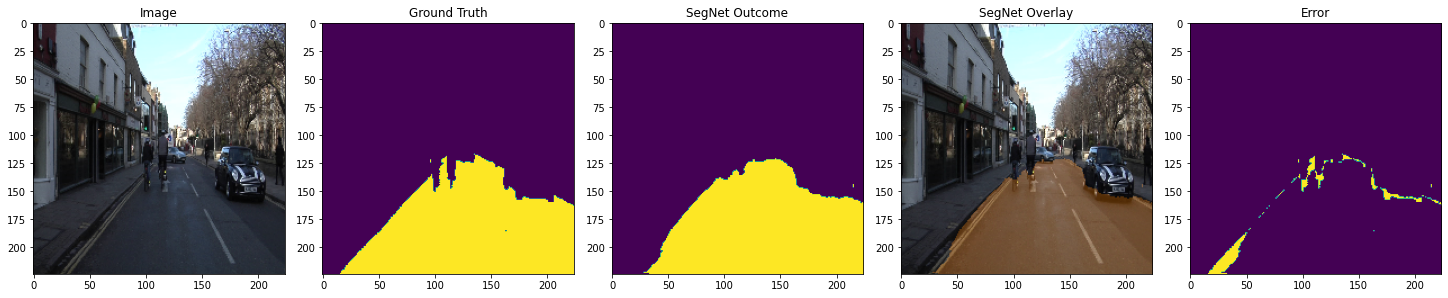

Epoch #181	Loss: 1.737700	Train Acc: 97.884%	Valid Acc: 97.696%	Time: 5.42s
Epoch #182	Loss: 1.666576	Train Acc: 97.884%	Valid Acc: 97.689%	Time: 5.43s
Epoch #183	Loss: 1.682353	Train Acc: 97.837%	Valid Acc: 97.620%	Time: 5.42s
Epoch #184	Loss: 1.723204	Train Acc: 97.865%	Valid Acc: 97.708%	Time: 5.45s
Epoch #185	Loss: 1.686365	Train Acc: 97.873%	Valid Acc: 97.720%	Time: 5.42s
Epoch #186	Loss: 1.715410	Train Acc: 97.911%	Valid Acc: 97.745%	Time: 5.43s
Epoch #187	Loss: 1.715052	Train Acc: 97.921%	Valid Acc: 97.755%	Time: 5.43s
Epoch #188	Loss: 1.692093	Train Acc: 97.846%	Valid Acc: 97.716%	Time: 5.44s
Epoch #189	Loss: 1.697939	Train Acc: 97.930%	Valid Acc: 97.790%	Time: 5.44s
Epoch #190	Loss: 1.709694	Train Acc: 97.882%	Valid Acc: 97.748%	Time: 5.43s


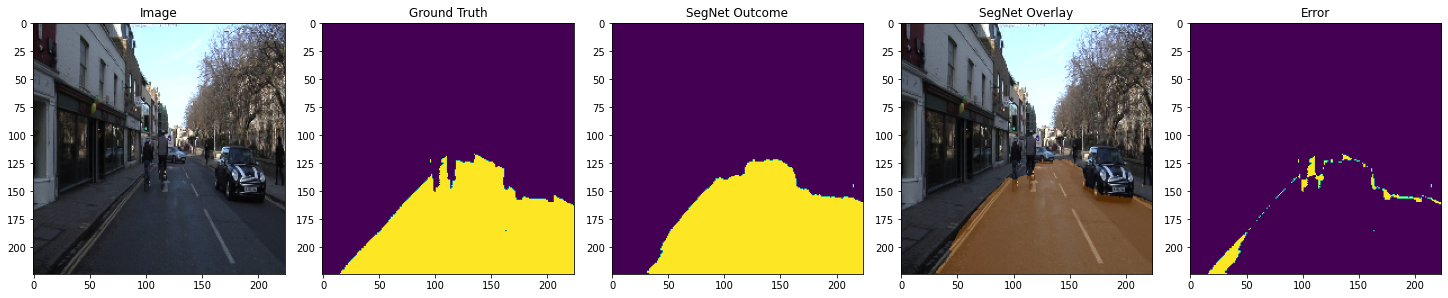

Epoch #191	Loss: 1.702995	Train Acc: 97.860%	Valid Acc: 97.701%	Time: 5.46s
Epoch #192	Loss: 1.663373	Train Acc: 97.874%	Valid Acc: 97.709%	Time: 5.42s
Epoch #193	Loss: 1.755790	Train Acc: 97.861%	Valid Acc: 97.707%	Time: 5.41s
Epoch #194	Loss: 1.687824	Train Acc: 97.897%	Valid Acc: 97.762%	Time: 5.42s
Epoch #195	Loss: 1.680174	Train Acc: 97.890%	Valid Acc: 97.715%	Time: 5.39s
Epoch #196	Loss: 1.690476	Train Acc: 97.870%	Valid Acc: 97.732%	Time: 5.43s
Epoch #197	Loss: 1.730239	Train Acc: 97.910%	Valid Acc: 97.741%	Time: 5.40s
Epoch #198	Loss: 1.710059	Train Acc: 97.912%	Valid Acc: 97.783%	Time: 5.41s
Epoch #199	Loss: 1.772176	Train Acc: 97.900%	Valid Acc: 97.726%	Time: 5.38s
<=============== Learning Rate 5.0805263425290855e-06 -> 1.6935087808430284e-06===== ==========>
Epoch #200	Loss: 1.692577	Train Acc: 97.798%	Valid Acc: 97.622%	Time: 5.40s


In [136]:
TRANSFER_LEARNING = False
model = SegNet(3,2, transfer_learning=TRANSFER_LEARNING).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = nn.CrossEntropyLoss(weight=LABEL_WEIGHTS).to(DEVICE)


# Launch training
torch.cuda.empty_cache()
train(model, optimizer, loss, X_train, y_train, X_valid, y_valid)


### Train from VGG weights


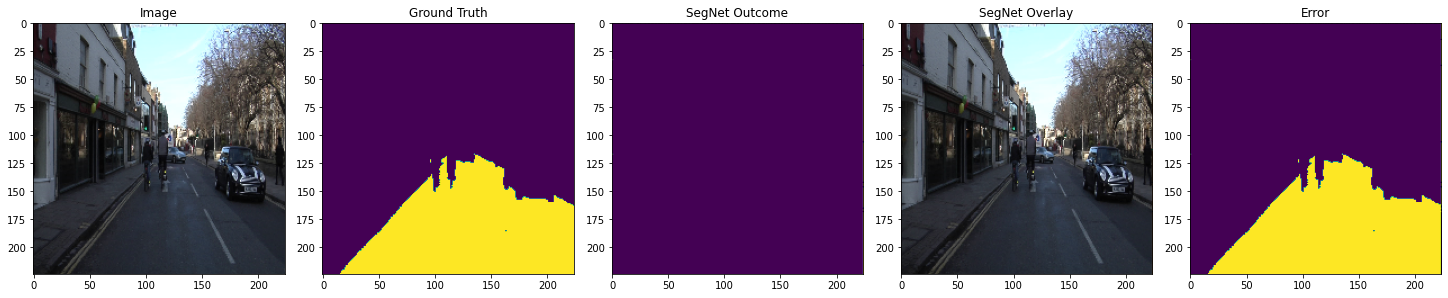

Epoch #1	Loss: 58.155727	Train Acc: 31.215%	Valid Acc: 28.865%	Time: 5.62s
Epoch #2	Loss: 27.676680	Train Acc: 31.215%	Valid Acc: 28.865%	Time: 5.61s
Epoch #3	Loss: 25.029797	Train Acc: 79.474%	Valid Acc: 83.735%	Time: 5.63s
Epoch #4	Loss: 12.500727	Train Acc: 92.431%	Valid Acc: 90.727%	Time: 5.61s
Epoch #5	Loss: 7.184542	Train Acc: 93.067%	Valid Acc: 91.615%	Time: 5.64s
Epoch #6	Loss: 6.212440	Train Acc: 94.248%	Valid Acc: 92.457%	Time: 5.60s
Epoch #7	Loss: 5.719403	Train Acc: 92.384%	Valid Acc: 88.983%	Time: 5.62s
Epoch #8	Loss: 5.001617	Train Acc: 93.841%	Valid Acc: 90.230%	Time: 5.62s
Epoch #9	Loss: 4.753971	Train Acc: 92.918%	Valid Acc: 88.250%	Time: 5.64s
Epoch #10	Loss: 5.107367	Train Acc: 95.895%	Valid Acc: 94.854%	Time: 5.65s


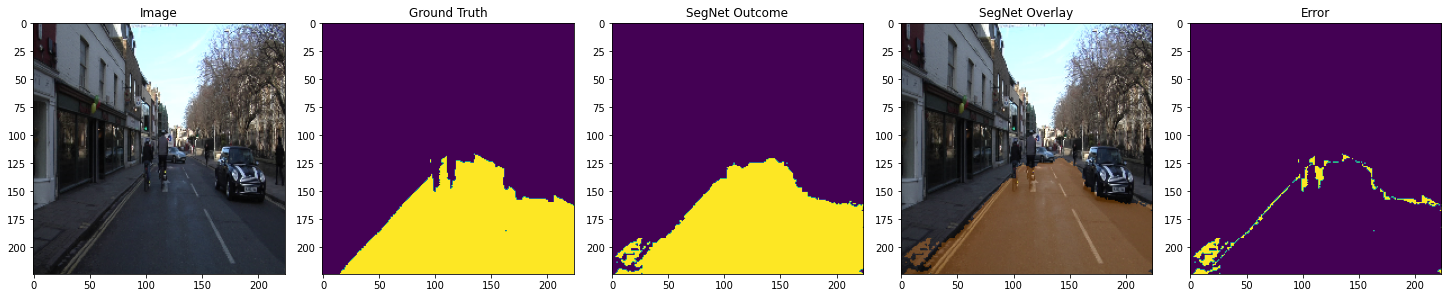

Epoch #11	Loss: 4.809389	Train Acc: 94.599%	Valid Acc: 92.073%	Time: 5.67s
Epoch #12	Loss: 4.159363	Train Acc: 95.195%	Valid Acc: 92.878%	Time: 5.61s
Epoch #13	Loss: 4.419353	Train Acc: 96.117%	Valid Acc: 94.896%	Time: 5.58s
Epoch #14	Loss: 4.483461	Train Acc: 95.948%	Valid Acc: 96.251%	Time: 5.59s
Epoch #15	Loss: 3.990282	Train Acc: 94.056%	Valid Acc: 92.132%	Time: 5.55s
Epoch #16	Loss: 3.877365	Train Acc: 95.626%	Valid Acc: 94.909%	Time: 5.56s
Epoch #17	Loss: 3.547109	Train Acc: 94.226%	Valid Acc: 92.867%	Time: 5.55s
Epoch #18	Loss: 3.670635	Train Acc: 92.339%	Valid Acc: 88.104%	Time: 5.55s
Epoch #19	Loss: 3.757941	Train Acc: 96.103%	Valid Acc: 95.344%	Time: 5.55s
<=============== Learning Rate 0.1 -> 0.03333333333333333===== ==========>
Epoch #20	Loss: 3.383269	Train Acc: 96.365%	Valid Acc: 95.401%	Time: 5.56s


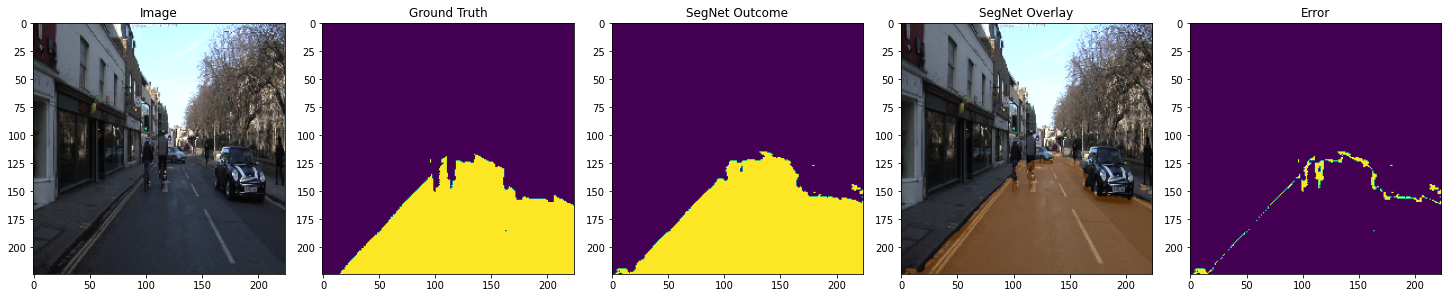

Epoch #21	Loss: 3.220616	Train Acc: 96.193%	Valid Acc: 95.602%	Time: 5.59s
Epoch #22	Loss: 2.935164	Train Acc: 96.005%	Valid Acc: 95.440%	Time: 5.59s
Epoch #23	Loss: 2.947515	Train Acc: 96.304%	Valid Acc: 96.425%	Time: 5.60s
Epoch #24	Loss: 2.879434	Train Acc: 97.082%	Valid Acc: 97.298%	Time: 5.58s
Epoch #25	Loss: 2.781847	Train Acc: 96.977%	Valid Acc: 97.663%	Time: 5.59s
Epoch #26	Loss: 2.721081	Train Acc: 94.018%	Valid Acc: 91.287%	Time: 5.59s
Epoch #27	Loss: 3.040366	Train Acc: 97.046%	Valid Acc: 97.686%	Time: 5.61s
Epoch #28	Loss: 2.886672	Train Acc: 96.799%	Valid Acc: 96.421%	Time: 5.58s
Epoch #29	Loss: 2.656837	Train Acc: 96.197%	Valid Acc: 96.125%	Time: 5.57s
Epoch #30	Loss: 2.752727	Train Acc: 96.688%	Valid Acc: 96.601%	Time: 5.58s


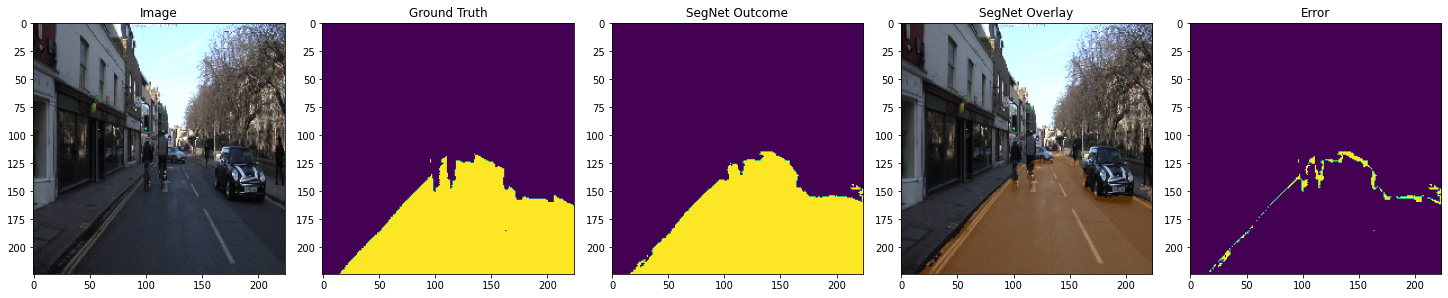

Epoch #31	Loss: 2.702725	Train Acc: 96.552%	Valid Acc: 96.852%	Time: 5.57s
Epoch #32	Loss: 2.698264	Train Acc: 96.872%	Valid Acc: 97.175%	Time: 5.62s
Epoch #33	Loss: 2.726265	Train Acc: 97.228%	Valid Acc: 97.049%	Time: 5.61s
Epoch #34	Loss: 2.557285	Train Acc: 96.107%	Valid Acc: 95.665%	Time: 5.60s
Epoch #35	Loss: 2.606479	Train Acc: 96.579%	Valid Acc: 96.557%	Time: 5.57s
Epoch #36	Loss: 2.614396	Train Acc: 96.510%	Valid Acc: 97.185%	Time: 5.60s
Epoch #37	Loss: 2.602981	Train Acc: 97.179%	Valid Acc: 97.546%	Time: 5.58s
Epoch #38	Loss: 2.585383	Train Acc: 96.682%	Valid Acc: 97.126%	Time: 5.65s
Epoch #39	Loss: 2.330209	Train Acc: 96.988%	Valid Acc: 97.077%	Time: 5.59s
<=============== Learning Rate 0.03333333333333333 -> 0.011111111111111112===== ==========>
Epoch #40	Loss: 2.251180	Train Acc: 97.538%	Valid Acc: 97.662%	Time: 5.63s


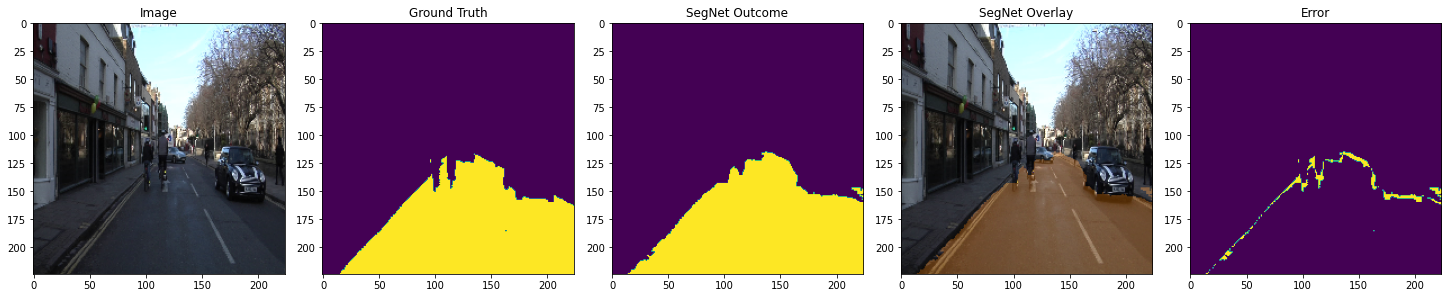

Epoch #41	Loss: 2.123983	Train Acc: 97.430%	Valid Acc: 97.613%	Time: 5.63s
Epoch #42	Loss: 2.040403	Train Acc: 97.477%	Valid Acc: 97.380%	Time: 5.65s
Epoch #43	Loss: 2.044166	Train Acc: 97.529%	Valid Acc: 97.361%	Time: 5.63s
Epoch #44	Loss: 2.038124	Train Acc: 97.462%	Valid Acc: 97.370%	Time: 5.60s
Epoch #45	Loss: 2.059861	Train Acc: 97.913%	Valid Acc: 97.774%	Time: 5.64s
Epoch #46	Loss: 2.054203	Train Acc: 97.917%	Valid Acc: 97.856%	Time: 5.63s
/content/gdrive/MyDrive/Segmentation/check_points/Epoch46_loss2.0542_trainacc97.917_valacc97.856.pth
Epoch #47	Loss: 1.990077	Train Acc: 97.760%	Valid Acc: 97.617%	Time: 5.76s
Epoch #48	Loss: 1.922630	Train Acc: 97.420%	Valid Acc: 97.018%	Time: 5.84s
Epoch #49	Loss: 1.903239	Train Acc: 97.670%	Valid Acc: 97.429%	Time: 5.85s
Epoch #50	Loss: 1.981231	Train Acc: 97.398%	Valid Acc: 97.304%	Time: 5.80s


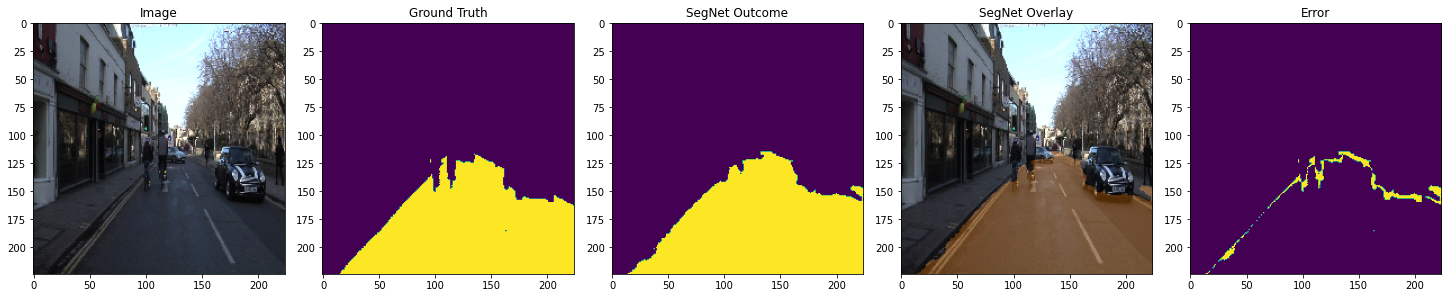

Epoch #51	Loss: 1.929407	Train Acc: 97.721%	Valid Acc: 97.111%	Time: 5.78s
Epoch #52	Loss: 1.847874	Train Acc: 97.803%	Valid Acc: 97.427%	Time: 5.76s
Epoch #53	Loss: 1.856454	Train Acc: 98.020%	Valid Acc: 97.637%	Time: 5.78s
Epoch #54	Loss: 1.938313	Train Acc: 97.799%	Valid Acc: 97.701%	Time: 5.74s
Epoch #55	Loss: 1.804607	Train Acc: 97.441%	Valid Acc: 96.961%	Time: 5.80s
Epoch #56	Loss: 1.789903	Train Acc: 97.849%	Valid Acc: 97.777%	Time: 5.78s
Epoch #57	Loss: 1.806386	Train Acc: 97.869%	Valid Acc: 97.489%	Time: 5.74s
Epoch #58	Loss: 1.701530	Train Acc: 97.758%	Valid Acc: 97.095%	Time: 5.75s
Epoch #59	Loss: 1.721753	Train Acc: 98.005%	Valid Acc: 97.398%	Time: 5.75s
<=============== Learning Rate 0.011111111111111112 -> 0.003703703703703704===== ==========>
Epoch #60	Loss: 1.633695	Train Acc: 98.107%	Valid Acc: 97.535%	Time: 5.78s


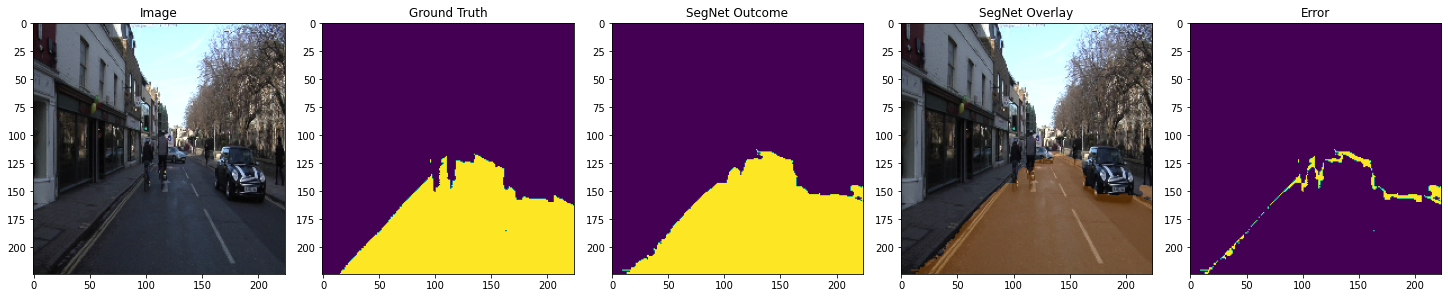

Epoch #61	Loss: 1.597994	Train Acc: 97.912%	Valid Acc: 97.510%	Time: 5.76s
Epoch #62	Loss: 1.614140	Train Acc: 97.989%	Valid Acc: 97.371%	Time: 5.79s
Epoch #63	Loss: 1.597193	Train Acc: 98.088%	Valid Acc: 97.460%	Time: 5.81s
Epoch #64	Loss: 1.596363	Train Acc: 97.997%	Valid Acc: 97.571%	Time: 5.78s
Epoch #65	Loss: 1.584786	Train Acc: 98.116%	Valid Acc: 97.587%	Time: 5.79s
Epoch #66	Loss: 1.567257	Train Acc: 98.098%	Valid Acc: 97.453%	Time: 5.79s
Epoch #67	Loss: 1.547109	Train Acc: 98.202%	Valid Acc: 97.635%	Time: 5.78s
Epoch #68	Loss: 1.537116	Train Acc: 98.258%	Valid Acc: 97.636%	Time: 5.80s
Epoch #69	Loss: 1.526652	Train Acc: 98.137%	Valid Acc: 97.250%	Time: 5.77s
Epoch #70	Loss: 1.522420	Train Acc: 98.142%	Valid Acc: 97.390%	Time: 5.78s


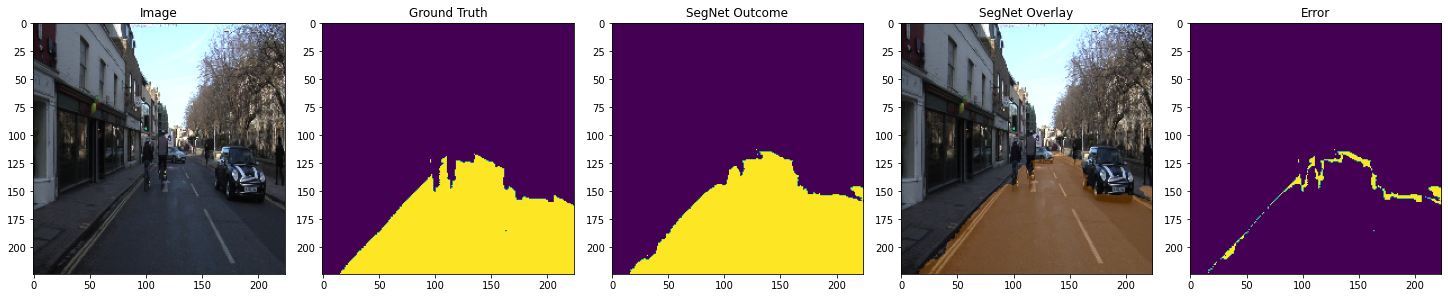

Epoch #71	Loss: 1.509411	Train Acc: 98.168%	Valid Acc: 97.680%	Time: 5.78s
Epoch #72	Loss: 1.484222	Train Acc: 98.155%	Valid Acc: 97.584%	Time: 5.76s
Epoch #73	Loss: 1.482199	Train Acc: 98.112%	Valid Acc: 97.455%	Time: 5.79s
Epoch #74	Loss: 1.529739	Train Acc: 98.092%	Valid Acc: 97.363%	Time: 5.79s
Epoch #75	Loss: 1.477893	Train Acc: 98.187%	Valid Acc: 97.650%	Time: 5.79s
Epoch #76	Loss: 1.461451	Train Acc: 98.323%	Valid Acc: 97.487%	Time: 5.79s
Epoch #77	Loss: 1.555079	Train Acc: 98.008%	Valid Acc: 97.191%	Time: 5.77s
Epoch #78	Loss: 1.497885	Train Acc: 98.107%	Valid Acc: 97.417%	Time: 5.80s
Epoch #79	Loss: 1.441153	Train Acc: 98.346%	Valid Acc: 97.682%	Time: 5.75s
<=============== Learning Rate 0.003703703703703704 -> 0.0012345679012345679===== ==========>
Epoch #80	Loss: 1.394768	Train Acc: 98.291%	Valid Acc: 97.601%	Time: 5.77s


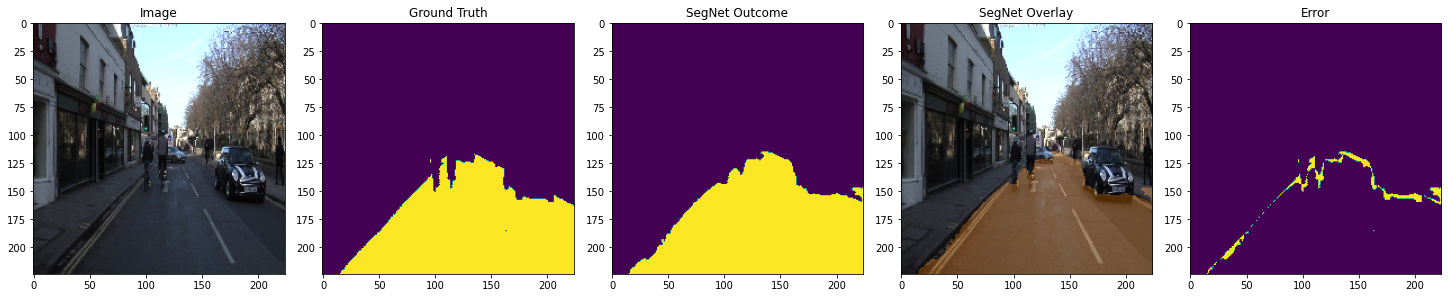

Epoch #81	Loss: 1.389111	Train Acc: 98.318%	Valid Acc: 97.597%	Time: 5.78s
Epoch #82	Loss: 1.409489	Train Acc: 98.294%	Valid Acc: 97.541%	Time: 5.77s
Epoch #83	Loss: 1.370845	Train Acc: 98.260%	Valid Acc: 97.566%	Time: 5.78s
Epoch #84	Loss: 1.381239	Train Acc: 98.283%	Valid Acc: 97.577%	Time: 5.77s
Epoch #85	Loss: 1.382333	Train Acc: 98.299%	Valid Acc: 97.580%	Time: 5.77s
Epoch #86	Loss: 1.376453	Train Acc: 98.293%	Valid Acc: 97.583%	Time: 5.79s
Epoch #87	Loss: 1.388113	Train Acc: 98.338%	Valid Acc: 97.564%	Time: 5.76s
Epoch #88	Loss: 1.372452	Train Acc: 98.263%	Valid Acc: 97.503%	Time: 5.79s
Epoch #89	Loss: 1.384200	Train Acc: 98.182%	Valid Acc: 97.563%	Time: 5.77s
Epoch #90	Loss: 1.368060	Train Acc: 98.395%	Valid Acc: 97.611%	Time: 5.78s


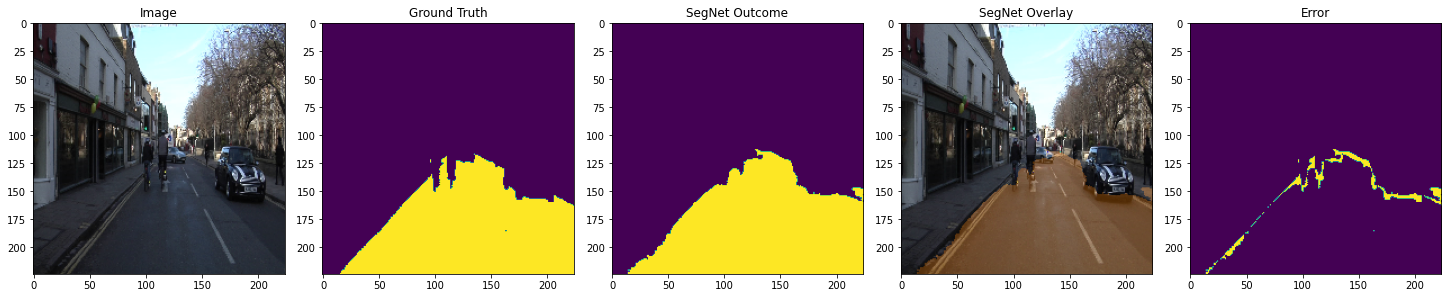

Epoch #91	Loss: 1.384987	Train Acc: 98.234%	Valid Acc: 97.495%	Time: 5.81s
Epoch #92	Loss: 1.406887	Train Acc: 98.324%	Valid Acc: 97.614%	Time: 5.84s
Epoch #93	Loss: 1.372308	Train Acc: 98.342%	Valid Acc: 97.566%	Time: 5.81s
Epoch #94	Loss: 1.366251	Train Acc: 98.305%	Valid Acc: 97.493%	Time: 5.81s
Epoch #95	Loss: 1.364324	Train Acc: 98.280%	Valid Acc: 97.622%	Time: 5.77s
Epoch #96	Loss: 1.415970	Train Acc: 98.237%	Valid Acc: 97.404%	Time: 5.77s
Epoch #97	Loss: 1.387829	Train Acc: 98.385%	Valid Acc: 97.646%	Time: 5.81s
Epoch #98	Loss: 1.369006	Train Acc: 98.265%	Valid Acc: 97.523%	Time: 5.80s
Epoch #99	Loss: 1.362243	Train Acc: 98.343%	Valid Acc: 97.535%	Time: 5.83s
<=============== Learning Rate 0.0012345679012345679 -> 0.00041152263374485596===== ==========>
Epoch #100	Loss: 1.361068	Train Acc: 98.316%	Valid Acc: 97.514%	Time: 5.74s


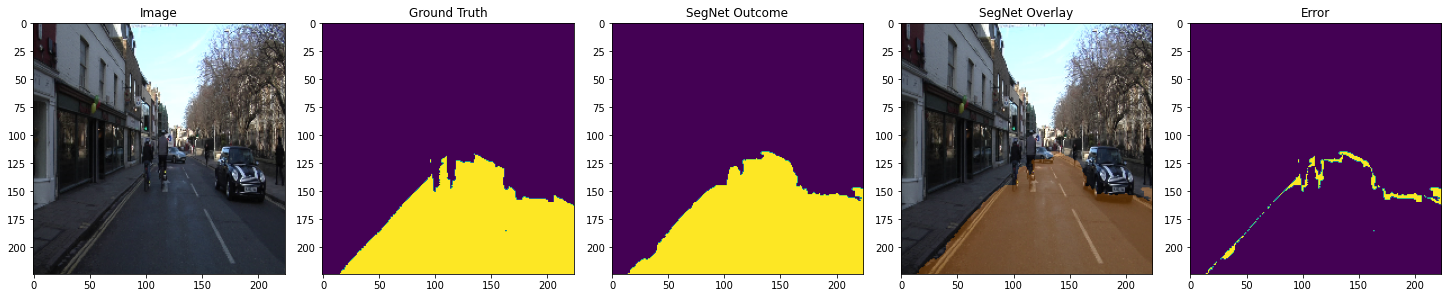

Epoch #101	Loss: 1.324056	Train Acc: 98.362%	Valid Acc: 97.620%	Time: 5.83s
Epoch #102	Loss: 1.339400	Train Acc: 98.403%	Valid Acc: 97.591%	Time: 5.80s
Epoch #103	Loss: 1.321310	Train Acc: 98.379%	Valid Acc: 97.578%	Time: 5.81s
Epoch #104	Loss: 1.308902	Train Acc: 98.385%	Valid Acc: 97.583%	Time: 5.82s
Epoch #105	Loss: 1.332191	Train Acc: 98.324%	Valid Acc: 97.441%	Time: 5.82s
Epoch #106	Loss: 1.348162	Train Acc: 98.359%	Valid Acc: 97.592%	Time: 5.80s
Epoch #107	Loss: 1.359245	Train Acc: 98.381%	Valid Acc: 97.596%	Time: 5.77s
Epoch #108	Loss: 1.314687	Train Acc: 98.380%	Valid Acc: 97.579%	Time: 5.77s
Epoch #109	Loss: 1.299543	Train Acc: 98.345%	Valid Acc: 97.613%	Time: 5.79s
Epoch #110	Loss: 1.334005	Train Acc: 98.362%	Valid Acc: 97.514%	Time: 5.73s


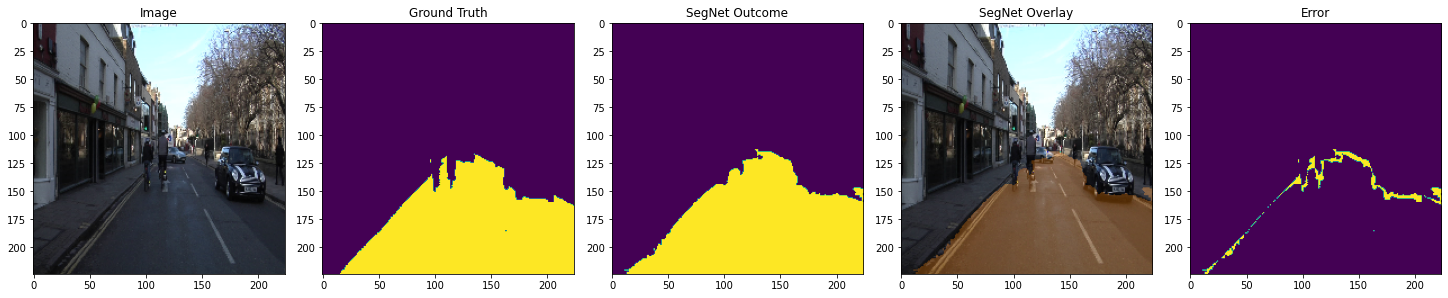

Epoch #111	Loss: 1.322336	Train Acc: 98.447%	Valid Acc: 97.593%	Time: 5.78s
Epoch #112	Loss: 1.314836	Train Acc: 98.391%	Valid Acc: 97.601%	Time: 5.79s
Epoch #113	Loss: 1.340529	Train Acc: 98.392%	Valid Acc: 97.491%	Time: 5.77s
Epoch #114	Loss: 1.307417	Train Acc: 98.345%	Valid Acc: 97.544%	Time: 5.77s
Epoch #115	Loss: 1.283553	Train Acc: 98.362%	Valid Acc: 97.517%	Time: 5.82s
Epoch #116	Loss: 1.314849	Train Acc: 98.259%	Valid Acc: 97.460%	Time: 5.78s
Epoch #117	Loss: 1.329112	Train Acc: 98.299%	Valid Acc: 97.491%	Time: 5.75s
Epoch #118	Loss: 1.328827	Train Acc: 98.343%	Valid Acc: 97.614%	Time: 5.76s
Epoch #119	Loss: 1.310160	Train Acc: 98.387%	Valid Acc: 97.594%	Time: 5.78s
<=============== Learning Rate 0.00041152263374485596 -> 0.00013717421124828533===== ==========>
Epoch #120	Loss: 1.284397	Train Acc: 98.434%	Valid Acc: 97.605%	Time: 5.81s


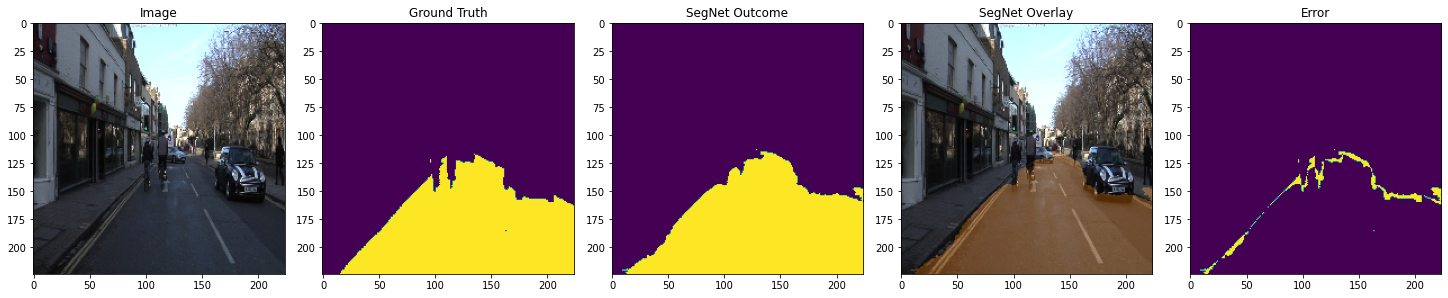

Epoch #121	Loss: 1.287425	Train Acc: 98.378%	Valid Acc: 97.606%	Time: 5.77s
Epoch #122	Loss: 1.287382	Train Acc: 98.392%	Valid Acc: 97.588%	Time: 5.76s
Epoch #123	Loss: 1.309404	Train Acc: 98.373%	Valid Acc: 97.598%	Time: 5.76s
Epoch #124	Loss: 1.277051	Train Acc: 98.376%	Valid Acc: 97.601%	Time: 5.76s
Epoch #125	Loss: 1.293287	Train Acc: 98.415%	Valid Acc: 97.625%	Time: 5.76s
Epoch #126	Loss: 1.311993	Train Acc: 98.392%	Valid Acc: 97.576%	Time: 5.77s
Epoch #127	Loss: 1.311336	Train Acc: 98.372%	Valid Acc: 97.574%	Time: 5.78s
Epoch #128	Loss: 1.281013	Train Acc: 98.384%	Valid Acc: 97.609%	Time: 5.79s
Epoch #129	Loss: 1.313233	Train Acc: 98.409%	Valid Acc: 97.655%	Time: 5.75s
Epoch #130	Loss: 1.282753	Train Acc: 98.406%	Valid Acc: 97.598%	Time: 5.78s


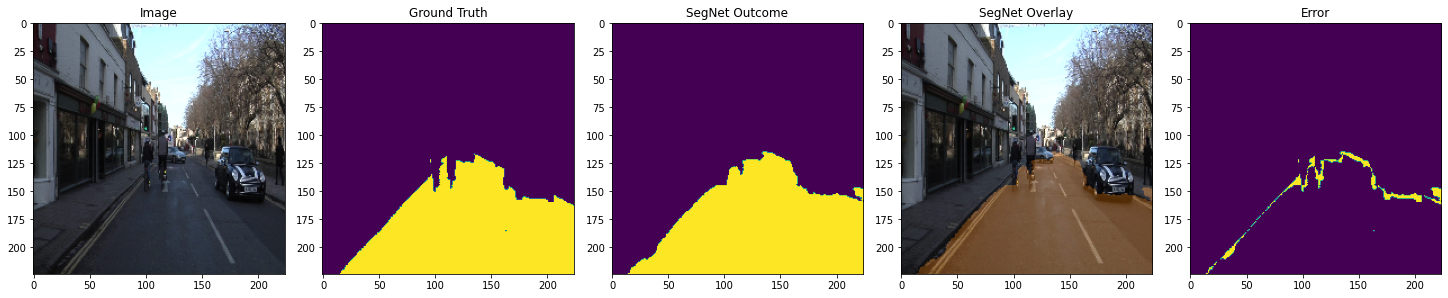

Epoch #131	Loss: 1.312080	Train Acc: 98.361%	Valid Acc: 97.584%	Time: 5.79s
Epoch #132	Loss: 1.281923	Train Acc: 98.418%	Valid Acc: 97.592%	Time: 5.78s
Epoch #133	Loss: 1.275737	Train Acc: 98.378%	Valid Acc: 97.575%	Time: 5.83s
Epoch #134	Loss: 1.277046	Train Acc: 98.423%	Valid Acc: 97.644%	Time: 5.78s
Epoch #135	Loss: 1.285116	Train Acc: 98.381%	Valid Acc: 97.600%	Time: 5.77s
Epoch #136	Loss: 1.269528	Train Acc: 98.393%	Valid Acc: 97.577%	Time: 5.75s
Epoch #137	Loss: 1.273140	Train Acc: 98.380%	Valid Acc: 97.617%	Time: 5.74s
Epoch #138	Loss: 1.295810	Train Acc: 98.378%	Valid Acc: 97.609%	Time: 5.79s
Epoch #139	Loss: 1.290002	Train Acc: 98.426%	Valid Acc: 97.645%	Time: 5.76s
<=============== Learning Rate 0.00013717421124828533 -> 4.5724737082761774e-05===== ==========>
Epoch #140	Loss: 1.295130	Train Acc: 98.376%	Valid Acc: 97.629%	Time: 5.77s


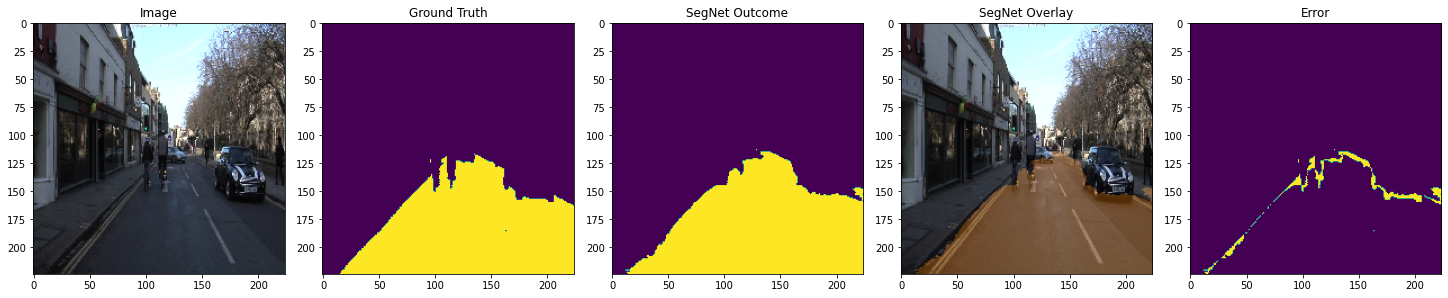

Epoch #141	Loss: 1.297699	Train Acc: 98.399%	Valid Acc: 97.603%	Time: 5.79s
Epoch #142	Loss: 1.274255	Train Acc: 98.413%	Valid Acc: 97.643%	Time: 5.77s
Epoch #143	Loss: 1.283098	Train Acc: 98.445%	Valid Acc: 97.656%	Time: 5.78s
Epoch #144	Loss: 1.273812	Train Acc: 98.405%	Valid Acc: 97.622%	Time: 5.78s
Epoch #145	Loss: 1.306910	Train Acc: 98.388%	Valid Acc: 97.562%	Time: 5.79s
Epoch #146	Loss: 1.256520	Train Acc: 98.396%	Valid Acc: 97.588%	Time: 5.77s
Epoch #147	Loss: 1.297173	Train Acc: 98.400%	Valid Acc: 97.629%	Time: 5.78s
Epoch #148	Loss: 1.273028	Train Acc: 98.392%	Valid Acc: 97.600%	Time: 5.78s
Epoch #149	Loss: 1.283772	Train Acc: 98.376%	Valid Acc: 97.615%	Time: 5.79s
Epoch #150	Loss: 1.318044	Train Acc: 98.394%	Valid Acc: 97.576%	Time: 5.76s


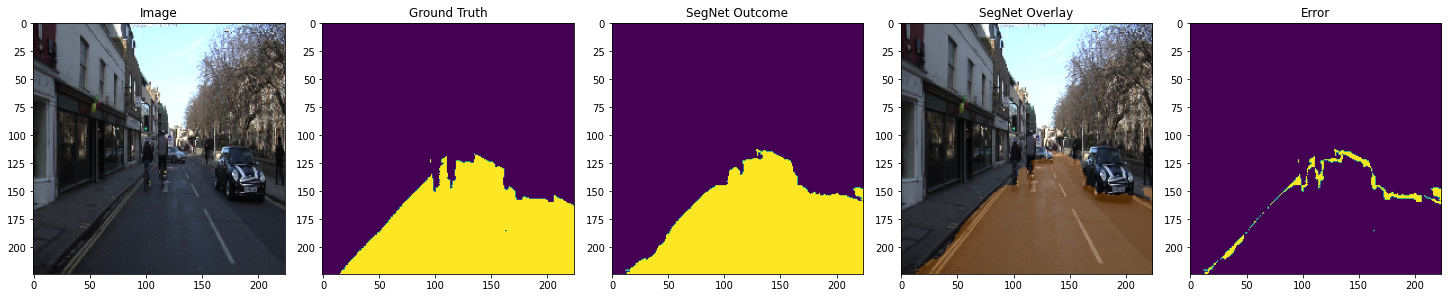

Epoch #151	Loss: 1.261373	Train Acc: 98.413%	Valid Acc: 97.538%	Time: 5.77s
Epoch #152	Loss: 1.284201	Train Acc: 98.439%	Valid Acc: 97.629%	Time: 5.77s
Epoch #153	Loss: 1.281658	Train Acc: 98.357%	Valid Acc: 97.517%	Time: 5.76s
Epoch #154	Loss: 1.271288	Train Acc: 98.400%	Valid Acc: 97.584%	Time: 5.79s
Epoch #155	Loss: 1.299466	Train Acc: 98.401%	Valid Acc: 97.608%	Time: 5.78s
Epoch #156	Loss: 1.282163	Train Acc: 98.376%	Valid Acc: 97.555%	Time: 5.74s
Epoch #157	Loss: 1.288244	Train Acc: 98.394%	Valid Acc: 97.612%	Time: 5.76s
Epoch #158	Loss: 1.294328	Train Acc: 98.399%	Valid Acc: 97.564%	Time: 5.77s
Epoch #159	Loss: 1.321451	Train Acc: 98.357%	Valid Acc: 97.518%	Time: 5.76s
<=============== Learning Rate 4.5724737082761774e-05 -> 1.5241579027587257e-05===== ==========>
Epoch #160	Loss: 1.274026	Train Acc: 98.429%	Valid Acc: 97.617%	Time: 5.79s


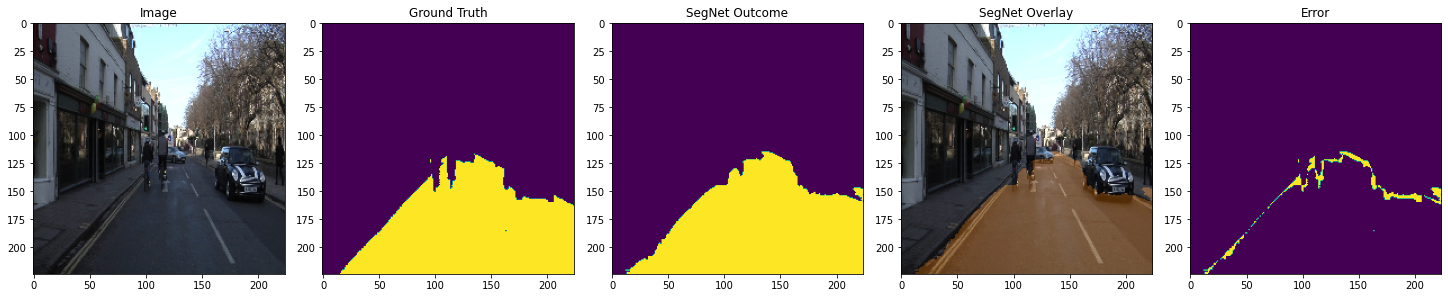

Epoch #161	Loss: 1.288321	Train Acc: 98.415%	Valid Acc: 97.600%	Time: 5.79s
Epoch #162	Loss: 1.279788	Train Acc: 98.444%	Valid Acc: 97.616%	Time: 5.81s
Epoch #163	Loss: 1.309308	Train Acc: 98.418%	Valid Acc: 97.606%	Time: 5.79s
Epoch #164	Loss: 1.284834	Train Acc: 98.423%	Valid Acc: 97.614%	Time: 5.80s
Epoch #165	Loss: 1.280739	Train Acc: 98.416%	Valid Acc: 97.569%	Time: 5.79s
Epoch #166	Loss: 1.296407	Train Acc: 98.410%	Valid Acc: 97.617%	Time: 5.80s
Epoch #167	Loss: 1.272230	Train Acc: 98.394%	Valid Acc: 97.560%	Time: 5.80s
Epoch #168	Loss: 1.274422	Train Acc: 98.479%	Valid Acc: 97.654%	Time: 5.82s
Epoch #169	Loss: 1.257349	Train Acc: 98.428%	Valid Acc: 97.624%	Time: 5.82s
Epoch #170	Loss: 1.281604	Train Acc: 98.422%	Valid Acc: 97.612%	Time: 5.77s


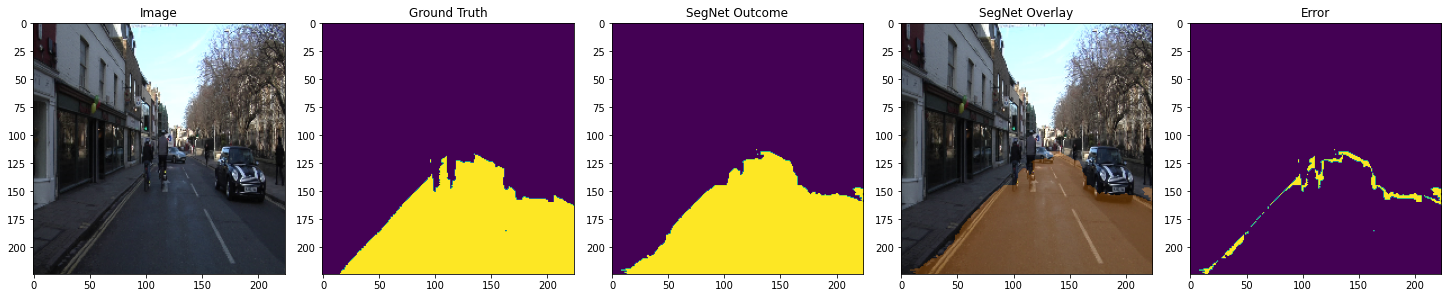

Epoch #171	Loss: 1.282734	Train Acc: 98.384%	Valid Acc: 97.518%	Time: 5.80s
Epoch #172	Loss: 1.278400	Train Acc: 98.431%	Valid Acc: 97.675%	Time: 5.78s
Epoch #173	Loss: 1.292989	Train Acc: 98.451%	Valid Acc: 97.635%	Time: 5.79s
Epoch #174	Loss: 1.269541	Train Acc: 98.441%	Valid Acc: 97.614%	Time: 5.83s
Epoch #175	Loss: 1.270960	Train Acc: 98.415%	Valid Acc: 97.613%	Time: 5.80s
Epoch #176	Loss: 1.310932	Train Acc: 98.410%	Valid Acc: 97.587%	Time: 5.75s
Epoch #177	Loss: 1.291896	Train Acc: 98.424%	Valid Acc: 97.616%	Time: 5.80s
Epoch #178	Loss: 1.320619	Train Acc: 98.345%	Valid Acc: 97.575%	Time: 5.78s
Epoch #179	Loss: 1.283540	Train Acc: 98.399%	Valid Acc: 97.574%	Time: 5.73s
<=============== Learning Rate 1.5241579027587256e-05 -> 5.0805263425290855e-06===== ==========>
Epoch #180	Loss: 1.281189	Train Acc: 98.410%	Valid Acc: 97.611%	Time: 5.70s


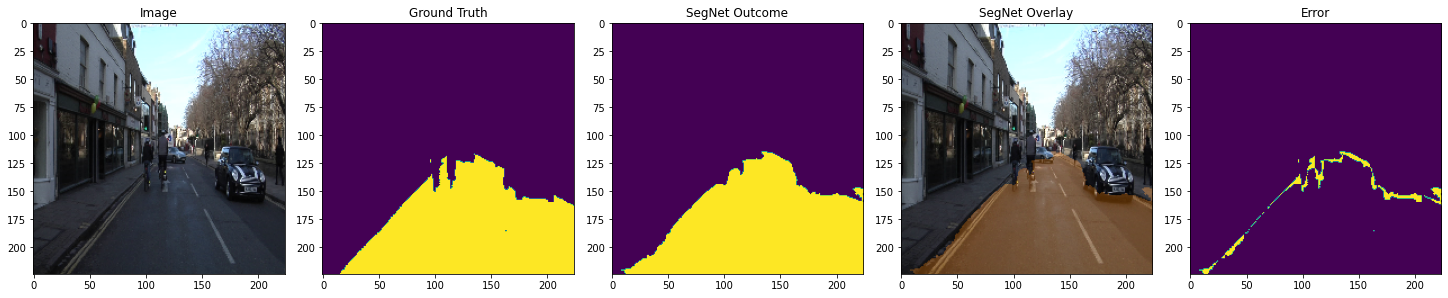

Epoch #181	Loss: 1.284941	Train Acc: 98.378%	Valid Acc: 97.581%	Time: 5.73s
Epoch #182	Loss: 1.312730	Train Acc: 98.362%	Valid Acc: 97.554%	Time: 5.70s
Epoch #183	Loss: 1.353982	Train Acc: 98.330%	Valid Acc: 97.539%	Time: 5.72s
Epoch #184	Loss: 1.282473	Train Acc: 98.379%	Valid Acc: 97.557%	Time: 5.72s
Epoch #185	Loss: 1.276341	Train Acc: 98.432%	Valid Acc: 97.637%	Time: 5.71s
Epoch #186	Loss: 1.260411	Train Acc: 98.415%	Valid Acc: 97.554%	Time: 5.69s
Epoch #187	Loss: 1.302563	Train Acc: 98.379%	Valid Acc: 97.570%	Time: 5.70s
Epoch #188	Loss: 1.272547	Train Acc: 98.422%	Valid Acc: 97.608%	Time: 5.75s
Epoch #189	Loss: 1.317185	Train Acc: 98.402%	Valid Acc: 97.577%	Time: 5.71s
Epoch #190	Loss: 1.262144	Train Acc: 98.416%	Valid Acc: 97.637%	Time: 5.70s


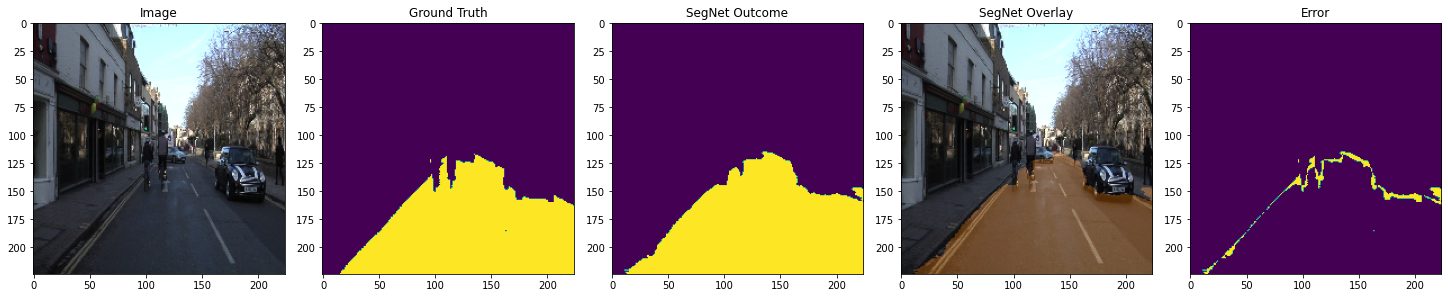

Epoch #191	Loss: 1.340774	Train Acc: 98.397%	Valid Acc: 97.585%	Time: 5.71s
Epoch #192	Loss: 1.276938	Train Acc: 98.409%	Valid Acc: 97.602%	Time: 5.77s
Epoch #193	Loss: 1.282093	Train Acc: 98.387%	Valid Acc: 97.564%	Time: 5.75s
Epoch #194	Loss: 1.275765	Train Acc: 98.414%	Valid Acc: 97.637%	Time: 5.74s
Epoch #195	Loss: 1.298455	Train Acc: 98.422%	Valid Acc: 97.544%	Time: 5.74s
Epoch #196	Loss: 1.291528	Train Acc: 98.406%	Valid Acc: 97.603%	Time: 5.69s
Epoch #197	Loss: 1.270578	Train Acc: 98.387%	Valid Acc: 97.574%	Time: 5.71s
Epoch #198	Loss: 1.316452	Train Acc: 98.415%	Valid Acc: 97.623%	Time: 5.70s
Epoch #199	Loss: 1.298339	Train Acc: 98.410%	Valid Acc: 97.597%	Time: 5.72s
<=============== Learning Rate 5.0805263425290855e-06 -> 1.6935087808430284e-06===== ==========>
Epoch #200	Loss: 1.313726	Train Acc: 98.364%	Valid Acc: 97.560%	Time: 5.73s


In [140]:
TRANSFER_LEARNING = True
model_vgginit = SegNet(3, 2, transfer_learning=TRANSFER_LEARNING).to(DEVICE)
optimizer = torch.optim.Adam(model_vgginit.parameters(), lr=LEARNING_RATE)
loss = nn.CrossEntropyLoss(weight=LABEL_WEIGHTS).to(DEVICE)

# Launch training
torch.cuda.empty_cache()
train(model_vgginit, optimizer, loss, X_train, y_train, X_valid, y_valid)


### Load model

Model Loaded: Epoch#73	Loss:1.9815	TrainAcc:97.8620	ValidAcc:98.0195


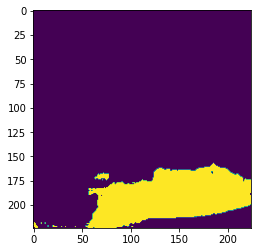

In [32]:
model_name = r'Epoch73_loss1.9815_trainacc97.862_valacc98.019.pth'
model_load = load_checkpoints(model_name)


show_pred_mask(model_load, X_train[0, :])

## Report Evaluation results on test dataset


In [141]:
model_selected = model3
test_dataset = data.CamVidDataset(X_test, y_test)
test_accuracy = avg_pixelwise_accuracy(model_selected, test_dataset)
print("Selected model's pixelwise accuracy on test dataset : {:.5f}%".format(test_accuracy * 100))

Selected model's pixelwise accuracy on test dataset : 92.32943%


## Visualization Output

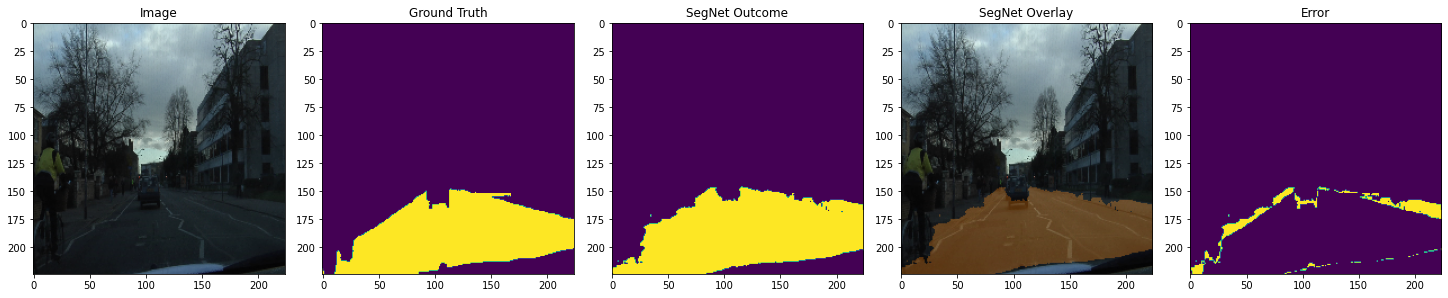

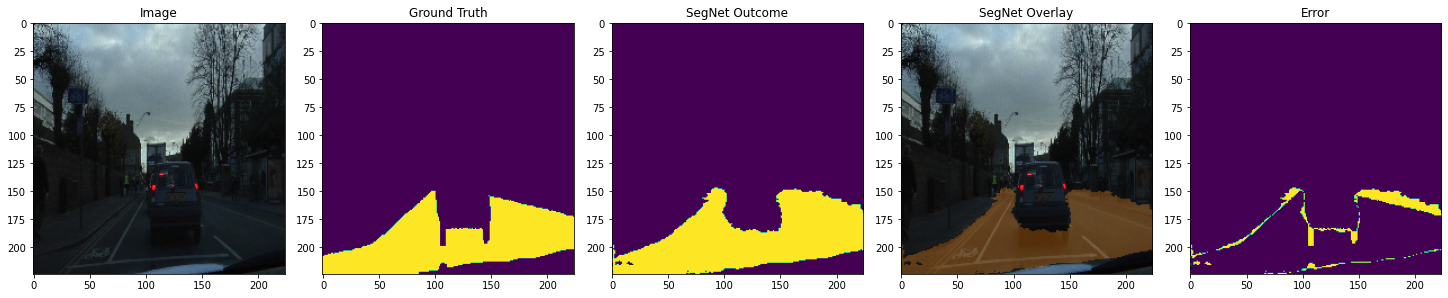

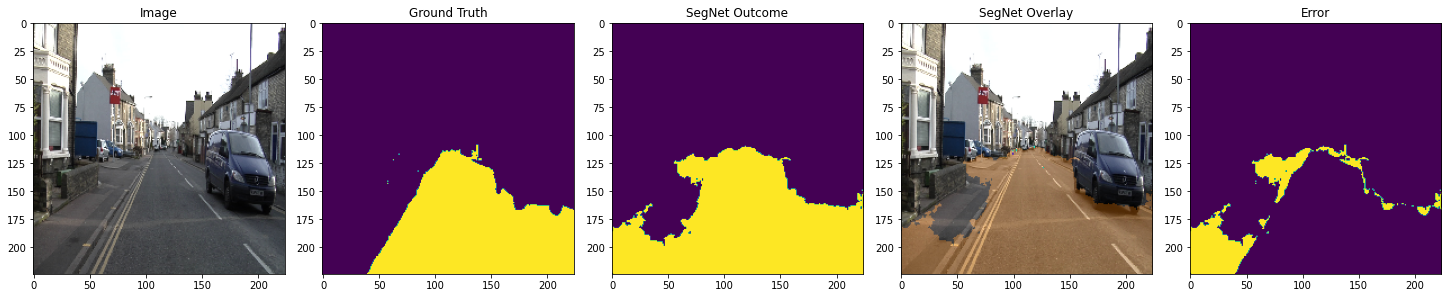

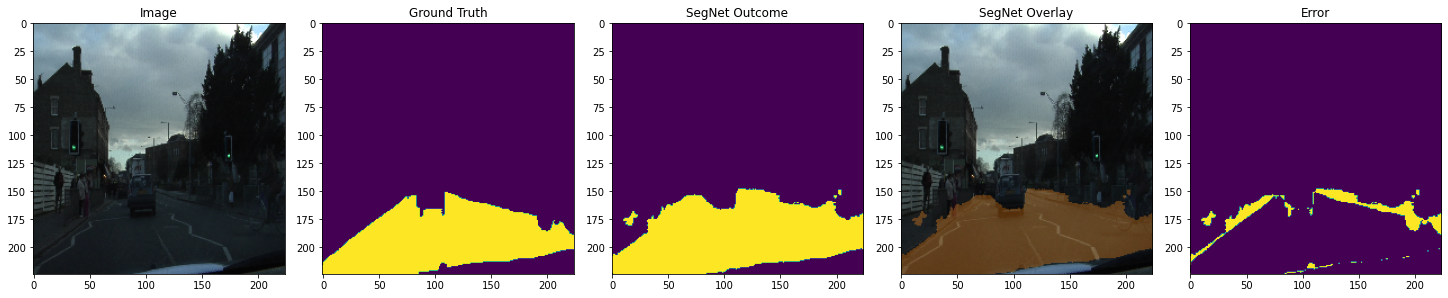

In [142]:
# visualize a single input image
# show_img(X_test[0, :])
# show_mask(y_test[0, 1, :])
# show_pred_mask(model_load, X_test[0, :])


# cmap = 'prism'
# cmap = 'brg'
# cmap = 'Paired'
# cmap = 'jet'
show_all(model3, X_test[2, :], y_test[2, 1, :], cmap='jet')
show_all(model3, X_test[11, :], y_test[11, 1, :], cmap='jet')
show_all(model3, X_test[-2, :], y_test[-2, 1, :], cmap='jet')
show_all(model3, X_test[43, :], y_test[43, 1, :], cmap='jet')

## *Demostration*

On Demo.py